Import vital libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
from matplotlib import pyplot as plt
from optbinning import Scorecard, BinningProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

(CVXPY) May 31 12:51:45 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 31 12:51:45 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


Load customer data from xslx file

In [2]:
dulieuktl = pd.read_excel("C:/Users/HANG/Downloads/du_lieu_mo_hinh.xlsx")
dulieuktl.head(10)

,y,areaname,gender,education,marital_status,residential_status,occupation,employment_type,salary_account_flag,New_existing,...,loan_to_income,loan_to_salary,loan_requested_to_income,loan_requested_to_salary,ltv,loan_expense_to_main_income,loan_to_main_income,loan_requested_to_main_income,Customer_to_total_income,Salary_to_total_income
0,0,Northern,M,University,Married,Owned house,Businessman,Registered business,N,New customer,...,NaN,NaN,NaN,NaN,73.39,NaN,NaN,NaN,NaN,NaN
1,1,Southern,M,University,Single,Owned house,Employee with bachelor/engineer,Manager,N,New customer,...,NaN,NaN,NaN,NaN,69.66,NaN,NaN,NaN,NaN,NaN
2,0,Southern,M,Diploma,Divorced/Widowed,Owned house,Staff,Manager,N,New customer,...,NaN,NaN,NaN,NaN,79.29,NaN,NaN,NaN,NaN,NaN
3,0,Northern,M,High school,Single,Living with parents,Own business,Worker or self-employed person,N,New customer,...,NaN,NaN,NaN,NaN,61.08,NaN,NaN,NaN,NaN,NaN
4,0,Southern,F,High school,Married,Owned house,Own business,Trained workers,N,New customer,...,NaN,NaN,NaN,NaN,60.11,NaN,NaN,NaN,NaN,NaN
5,0,Middle,M,College,Married,Owned house,Own business,Worker or self-employed person,N,New customer,...,NaN,NaN,NaN,NaN,58.82,NaN,NaN,NaN,NaN,NaN
6,0,Southern,M,High school,Married,Owned house,Own business,Trained workers,N,New customer,...,NaN,NaN,NaN,NaN,35.78,NaN,NaN,NaN,NaN,NaN
7,0,Middle,M,Diploma,Married,Owned house,Own business,Registered business,N,New customer,...,NaN,NaN,NaN,NaN,83.33,NaN,NaN,NaN,NaN,NaN
8,1,Southern,F,University,Divorced/Widowed,Living with parents,Staff,Manager,N,NaN,...,NaN,NaN,NaN,NaN,70.11,NaN,NaN,NaN,NaN,NaN
9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The A-score model for home loan is built based on Good/Bad statistical analysis using logistic regression. The model is designed as a scorecard.This process includes stages as follows:
1. Data cleaning;
2. Single factor analysis;
3. Variables transformation;
4. Multiple factor analysis;
5. Model validation.

In real-world context, more steps are necessary to be done and they are more complicated too. That is, at first preparing the long list of variables and especially the stage of collecting, preparing data and process them before using is very time-consuming; and after all, there will be pooling and PD calibration steps. However, due to the lack of time and knowledge, I am just able to guide you through my process as listed above.

1. Data cleaning

In [3]:
dulieuktl.shape

(7235, 47)

My model building sample has 7235 observations, and I have an available list of 46 characteristics of customers. These potential charactistics are supposed to be meaningful in real business (i.e evident to affect the default probability of customers).

In [4]:
dulieuktl.columns

Index(['y', 'areaname', 'gender', 'education', 'marital_status',
       'residential_status', 'occupation', 'employment_type',
       'salary_account_flag', 'New_existing', 'collateral_type',
       'copayer_flag', 'CL_type_flag', 'type_of_col', 'loan_amount',
       'salary_copayer', 'dependants', 'customers_income', 'copayers_income',
       'total_asset_value', 'months_at_mb', 'account_value', 'no_of_product',
       'no_of_copayers', 'age_in_yrs', 'total_income', 'salary_income',
       'total_expense', 'new_collateral_value', 'downpayment', 'net_income',
       'job_exp_years', 'no_income_type', 'downpayment_ratio',
       'loan_to_collateral_value', 'expense_to_income', 'expense_to_salary',
       'loan_to_income', 'loan_to_salary', 'loan_requested_to_income',
       'loan_requested_to_salary', 'ltv', 'loan_expense_to_main_income',
       'loan_to_main_income', 'loan_requested_to_main_income',
       'Customer_to_total_income', 'Salary_to_total_income'],
      dtype='object')

Checking if there is any duplicated observation; missing, illogical value or outlier from each column

In [5]:
duplicateRows = dulieuktl[dulieuktl.duplicated()].values
duplicateRows

array([], shape=(0, 47), dtype=object)

=> There is not duplicated row though

In [6]:
dulieuktl.loc[:, dulieuktl.columns!='y'].isnull().sum()

areaname                           64
gender                             64
education                          64
marital_status                     64
residential_status                 64
occupation                         64
employment_type                    71
salary_account_flag                64
New_existing                     3819
collateral_type                     1
copayer_flag                     1008
CL_type_flag                        0
type_of_col                       234
loan_amount                        94
salary_copayer                   5209
dependants                         64
customers_income                   64
copayers_income                    69
total_asset_value                  67
months_at_mb                       64
account_value                      64
no_of_product                      64
no_of_copayers                   1008
age_in_yrs                          0
total_income                        0
salary_income                       0
total_expens

In [7]:
dulieuktl.loc[:, dulieuktl.columns!='y'].eq(0).sum()

areaname                            0
gender                              0
education                           0
marital_status                      0
residential_status                  0
occupation                          0
employment_type                     0
salary_account_flag                 0
New_existing                        0
collateral_type                     0
copayer_flag                        0
CL_type_flag                        0
type_of_col                         0
loan_amount                         0
salary_copayer                      0
dependants                       2122
customers_income                  146
copayers_income                  4656
total_asset_value                2116
months_at_mb                     5848
account_value                    5949
no_of_product                    3145
no_of_copayers                      0
age_in_yrs                          0
total_income                       12
salary_income                    3931
total_expens

In [8]:
#Sollution:

+ Missing values:
-Exclude all data with missing values—this is complete case analysis, and in most financial industry cases, will likely result in very little data to work with;
-Exclude records that have significant (e.g.more than 50%) missing values from the model, especially if the level of missing is expected to continue in the future;
-Include characteristics with missing values in the scorecard. The “missing” can then be treated as a separate attribute, grouped, and used in regression as an input. The scorecard can then be allowed to assign weights to this attribute. In some cases this assigned weight may be close to the “neutral” or mean value, but in cases where the weight is closer to another attribute, it may shed light on the exact nature of the missing values;
-Impute missing values using statistical techniques.

I consider values 0 illogical and let them be treated as missing values.

In [9]:
df = dulieuktl.loc[:, dulieuktl.columns!='y'].isnull().sum()/len(dulieuktl.index)

In [10]:
df1 = dulieuktl.loc[:, dulieuktl.columns!='y'].eq(0).sum()/len(dulieuktl.index)

In [11]:
df2 = pd.DataFrame({'variable':df.index, 'rate_isnull':df.values, 'rate_eqzero': df1.values})

In [13]:
df2

,variable,rate_isnull,rate_eqzero
0,areaname,0.008846,0.000000
1,gender,0.008846,0.000000
2,education,0.008846,0.000000
3,marital_status,0.008846,0.000000
4,residential_status,0.008846,0.000000
5,occupation,0.008846,0.000000
6,employment_type,0.009813,0.000000
7,salary_account_flag,0.008846,0.000000
8,New_existing,0.527851,0.000000
9,collateral_type,0.000138,0.000000


In [12]:
df3 = df2[(df2['rate_isnull'] > 0.5) | (df2['rate_eqzero'] > 0.5)]
df3

,variable,rate_isnull,rate_eqzero
8,New_existing,0.527851,0.000000
14,salary_copayer,0.719972,0.000000
17,copayers_income,0.009537,0.643538
19,months_at_mb,0.008846,0.808293
20,account_value,0.008846,0.822253
25,salary_income,0.000000,0.543331
35,expense_to_salary,0.543469,0.000000
37,loan_to_salary,0.544990,0.000000
39,loan_requested_to_salary,0.544990,0.000000
45,Salary_to_total_income,0.543884,0.000000


=> There are 10 characteristics to be removed.

In [13]:
dulieuktl1 = dulieuktl.drop(dulieuktl.columns[[9,15,18,20,21,26,36,38,40,46]], axis = 1)
dulieuktl1

,y,areaname,gender,education,marital_status,residential_status,occupation,employment_type,salary_account_flag,collateral_type,...,downpayment_ratio,loan_to_collateral_value,expense_to_income,loan_to_income,loan_requested_to_income,ltv,loan_expense_to_main_income,loan_to_main_income,loan_requested_to_main_income,Customer_to_total_income
0,0,Northern,M,University,Married,Owned house,Businessman,Registered business,N,Only asset to be financed by the loan,...,26.96,100.49,NaN,NaN,NaN,73.39,NaN,NaN,NaN,NaN
1,1,Southern,M,University,Single,Owned house,Employee with bachelor/engineer,Manager,N,Only asset to be financed by the loan,...,30.34,100.00,NaN,NaN,NaN,69.66,NaN,NaN,NaN,NaN
2,0,Southern,M,Diploma,Divorced/Widowed,Owned house,Staff,Manager,N,Only asset to be financed by the loan,...,20.71,100.00,NaN,NaN,NaN,79.29,NaN,NaN,NaN,NaN
3,0,Northern,M,High school,Single,Living with parents,Own business,Worker or self-employed person,N,Only asset to be financed by the loan,...,34.82,93.72,NaN,NaN,NaN,61.08,NaN,NaN,NaN,NaN
4,0,Southern,F,High school,Married,Owned house,Own business,Trained workers,N,Only asset to be financed by the loan,...,39.89,100.00,NaN,NaN,NaN,60.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,0,Northern,M,Post graduate,Married,Owned house,Businessman,Manager,N,Only asset to be financed by the loan,...,20.00,100.00,22.02,335.25,268.20,80.00,19.05,335.25,268.20,100.0
7231,0,Middle,M,Post graduate,Divorced/Widowed,Owned house,Employee with bachelor/engineer,Manager,N,Only asset to be financed by the loan,...,20.58,100.00,78.81,1074.32,853.26,79.42,77.13,1074.32,853.26,100.0
7232,0,Northern,M,University,Single,Living with parents,Businessman,Registered business,N,Only asset to be financed by the loan,...,36.27,116.23,NaN,NaN,NaN,74.07,NaN,NaN,NaN,NaN
7233,0,Northern,M,University,Married,Owned house,Businessman,Manager,N,Only asset to be financed by the loan,...,20.00,100.00,NaN,NaN,NaN,80.00,NaN,NaN,NaN,NaN


In [14]:
col_names = ['y','dependants','no_of_copayers','no_income_type','no_of_product']
for col in col_names:
    dulieuktl1[col] = dulieuktl1[col].astype('category')

In [15]:
print(dulieuktl1.dtypes)

y                                category
areaname                           object
gender                             object
education                          object
marital_status                     object
residential_status                 object
occupation                         object
employment_type                    object
salary_account_flag                object
collateral_type                    object
copayer_flag                       object
CL_type_flag                       object
type_of_col                        object
loan_amount                       float64
dependants                       category
customers_income                  float64
total_asset_value                 float64
no_of_product                    category
no_of_copayers                   category
age_in_yrs                        float64
total_income                      float64
total_expense                       int64
new_collateral_value              float64
downpayment                       

In [16]:
col_names1 = dulieuktl1.select_dtypes(include = np.number).columns.values

In [19]:
col_names1

array(['loan_amount', 'customers_income', 'total_asset_value',
       'age_in_yrs', 'total_income', 'total_expense',
       'new_collateral_value', 'downpayment', 'net_income',
       'job_exp_years', 'downpayment_ratio', 'loan_to_collateral_value',
       'expense_to_income', 'loan_to_income', 'loan_requested_to_income',
       'ltv', 'loan_expense_to_main_income', 'loan_to_main_income',
       'loan_requested_to_main_income', 'Customer_to_total_income'],
      dtype=object)

In [17]:
for col in col_names1:
    dulieuktl1[col].replace(0, np.nan, inplace=True)

In [22]:
dulieuktl1.eq(0).sum()

y                                6754
areaname                            0
gender                              0
education                           0
marital_status                      0
residential_status                  0
occupation                          0
employment_type                     0
salary_account_flag                 0
collateral_type                     0
copayer_flag                        0
CL_type_flag                        0
type_of_col                         0
loan_amount                         0
dependants                       2122
customers_income                    0
total_asset_value                   0
no_of_product                    3145
no_of_copayers                      0
age_in_yrs                          0
total_income                        0
total_expense                       0
new_collateral_value                0
downpayment                         0
net_income                          0
job_exp_years                       0
no_income_ty

+ Outliers:
In each row, values stand outside the interval [(µ - 3σ);(µ + 3σ)] will be considerd outliers and converted to Nan values.

In [18]:
v = dulieuktl1.select_dtypes(include=np.number).values
mask = np.abs((v - v.mean(0)) / v.std(0)) > 3
df4 = pd.DataFrame(np.where(mask, np.nan, v), dulieuktl1.select_dtypes(include=np.number).index, dulieuktl1.select_dtypes(include=np.number).columns)
df4

,loan_amount,customers_income,total_asset_value,age_in_yrs,total_income,total_expense,new_collateral_value,downpayment,net_income,job_exp_years,downpayment_ratio,loan_to_collateral_value,expense_to_income,loan_to_income,loan_requested_to_income,ltv,loan_expense_to_main_income,loan_to_main_income,loan_requested_to_main_income,Customer_to_total_income
0,1.095360e+09,NaN,6.250000e+09,50.08,NaN,10000000.0,1.090000e+09,2.953600e+08,-1.000000e+07,13.67,26.96,100.49,NaN,NaN,NaN,73.39,NaN,NaN,NaN,NaN
1,1.292000e+09,NaN,NaN,29.33,NaN,5000000.0,1.292000e+09,3.920000e+08,-5.000000e+06,3.33,30.34,100.00,NaN,NaN,NaN,69.66,NaN,NaN,NaN,NaN
2,1.009000e+09,NaN,NaN,50.25,NaN,3000000.0,1.009000e+09,2.090000e+08,-3.000000e+06,2.42,20.71,100.00,NaN,NaN,NaN,79.29,NaN,NaN,NaN,NaN
3,5.370000e+08,NaN,1.870000e+08,23.92,NaN,10000000.0,5.730000e+08,1.870000e+08,-1.000000e+07,NaN,34.82,93.72,NaN,NaN,NaN,61.08,NaN,NaN,NaN,NaN
4,3.327000e+08,NaN,9.000000e+07,44.67,NaN,12000000.0,3.327000e+08,1.327000e+08,-1.200000e+07,1.67,39.89,100.00,NaN,NaN,NaN,60.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,2.816100e+09,8.400000e+08,2.238384e+10,54.17,8.400000e+08,185000000.0,2.816100e+09,5.632200e+08,6.550000e+08,6.00,20.00,100.00,22.02,335.25,268.20,80.00,19.05,335.25,268.20,100.0
7231,9.569000e+09,8.907000e+08,3.038600e+10,37.25,8.907000e+08,702000000.0,9.569000e+09,1.969000e+09,1.887000e+08,5.58,20.58,100.00,78.81,1074.32,853.26,79.42,77.13,1074.32,853.26,100.0
7232,3.138240e+09,1.084000e+09,NaN,33.50,1.084000e+09,5000000.0,2.700000e+09,1.138240e+09,1.079000e+09,4.50,36.27,116.23,NaN,NaN,NaN,74.07,NaN,NaN,NaN,NaN
7233,1.100000e+09,2.900000e+07,2.000000e+09,34.92,1.019300e+10,13500000.0,1.100000e+09,2.200000e+08,1.017950e+10,10.25,20.00,100.00,NaN,NaN,NaN,80.00,NaN,NaN,NaN,NaN


In [19]:
list = dulieuktl1.select_dtypes(include=[np.number]).columns

for x in list:
    dulieuktl1[x] = df4[x]
dulieuktl1

,y,areaname,gender,education,marital_status,residential_status,occupation,employment_type,salary_account_flag,collateral_type,...,downpayment_ratio,loan_to_collateral_value,expense_to_income,loan_to_income,loan_requested_to_income,ltv,loan_expense_to_main_income,loan_to_main_income,loan_requested_to_main_income,Customer_to_total_income
0,0,Northern,M,University,Married,Owned house,Businessman,Registered business,N,Only asset to be financed by the loan,...,26.96,100.49,NaN,NaN,NaN,73.39,NaN,NaN,NaN,NaN
1,1,Southern,M,University,Single,Owned house,Employee with bachelor/engineer,Manager,N,Only asset to be financed by the loan,...,30.34,100.00,NaN,NaN,NaN,69.66,NaN,NaN,NaN,NaN
2,0,Southern,M,Diploma,Divorced/Widowed,Owned house,Staff,Manager,N,Only asset to be financed by the loan,...,20.71,100.00,NaN,NaN,NaN,79.29,NaN,NaN,NaN,NaN
3,0,Northern,M,High school,Single,Living with parents,Own business,Worker or self-employed person,N,Only asset to be financed by the loan,...,34.82,93.72,NaN,NaN,NaN,61.08,NaN,NaN,NaN,NaN
4,0,Southern,F,High school,Married,Owned house,Own business,Trained workers,N,Only asset to be financed by the loan,...,39.89,100.00,NaN,NaN,NaN,60.11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7230,0,Northern,M,Post graduate,Married,Owned house,Businessman,Manager,N,Only asset to be financed by the loan,...,20.00,100.00,22.02,335.25,268.20,80.00,19.05,335.25,268.20,100.0
7231,0,Middle,M,Post graduate,Divorced/Widowed,Owned house,Employee with bachelor/engineer,Manager,N,Only asset to be financed by the loan,...,20.58,100.00,78.81,1074.32,853.26,79.42,77.13,1074.32,853.26,100.0
7232,0,Northern,M,University,Single,Living with parents,Businessman,Registered business,N,Only asset to be financed by the loan,...,36.27,116.23,NaN,NaN,NaN,74.07,NaN,NaN,NaN,NaN
7233,0,Northern,M,University,Married,Owned house,Businessman,Manager,N,Only asset to be financed by the loan,...,20.00,100.00,NaN,NaN,NaN,80.00,NaN,NaN,NaN,NaN


=> Finish the step of cleaning dataset; outliers and 0 were converted to Nan. Consider Nan as a distinct category in next steps, i.e missing group.

In [ ]:
#Before SFA stage, splitting our cleaned dataset into train and test sample

In [20]:
dulieuktl1_train, dulieuktl1_test, y_train, y_test = train_test_split(dulieuktl1, dulieuktl1.y, test_size=0.2, random_state=42)

2. Single factor analysis

2.1. Characteristics distribution and Good/Bad rate line 

In [22]:
dulieuktl1_train

,y,areaname,gender,education,marital_status,residential_status,occupation,employment_type,salary_account_flag,collateral_type,...,downpayment_ratio,loan_to_collateral_value,expense_to_income,loan_to_income,loan_requested_to_income,ltv,loan_expense_to_main_income,loan_to_main_income,loan_requested_to_main_income,Customer_to_total_income
371,1,Southern,F,High school,Married,Owned house,Own business,Registered business,N,Only asset to be financed by the loan,...,30.24,100.00,36.67,2198.00,1533.33,69.76,3.33,2198.00,1533.33,100.00
5101,0,Northern,M,University,Married,Owned house,Expert/Researcher,Specialist,N,Only asset to be financed by the loan,...,20.22,100.00,53.19,1306.72,1042.55,79.78,31.91,1306.72,1042.55,100.00
4139,0,Middle,M,Diploma,Married,Owned house,Own business,Worker or self-employed person,N,Only asset to be financed by the loan,...,39.74,103.34,19.44,3918.28,2361.11,62.27,2.78,3918.28,2361.11,100.00
1919,0,Northern,M,High school,Married,Owned house,Own business,Registered business,N,Only asset to be financed by the loan,...,50.00,100.00,65.22,1130.43,565.22,50.00,21.74,1130.43,565.22,100.00
4194,0,Middle,M,High school,Married,Owned house,Own business,Registered business,N,Only asset to be financed by the loan,...,93.76,100.00,35.62,3643.84,227.40,6.24,2.74,3643.84,227.40,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,Northern,M,Diploma,Married,Owned house,Other (retired…),Retired,N,Only independent asset,...,27.27,26.44,15.20,1672.31,1216.23,19.23,NaN,2245.94,1633.41,74.46
5191,0,Middle,M,Diploma,Married,Owned house,Own business,Registered business,N,Only asset to be financed by the loan,...,32.43,100.00,79.80,755.10,510.20,67.57,167.14,1761.90,1190.48,42.86
5226,0,Northern,M,Diploma,Married,Owned house,Own business,Registered business,N,Only asset to be financed by the loan,...,44.18,100.00,48.00,1254.00,700.00,55.82,30.00,1254.00,700.00,100.00
5390,0,Southern,F,High school,Married,Living with parents,Own business,Worker or self-employed person,N,Only asset to be financed by the loan,...,20.53,100.00,45.01,2954.99,2348.34,79.47,27.40,2954.99,2348.34,100.00


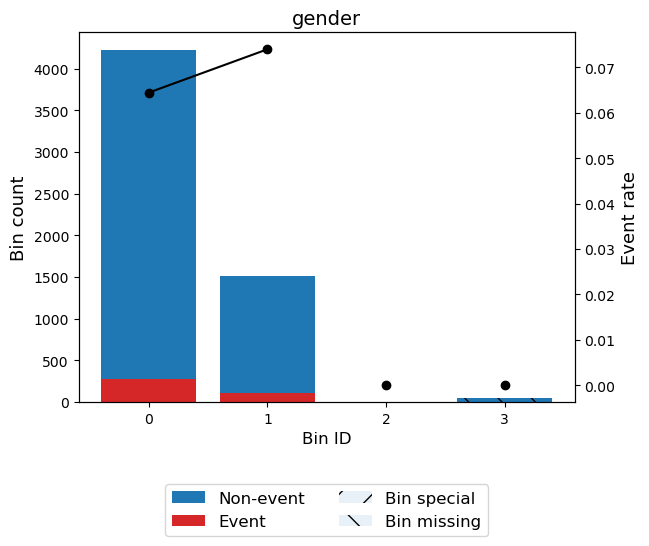

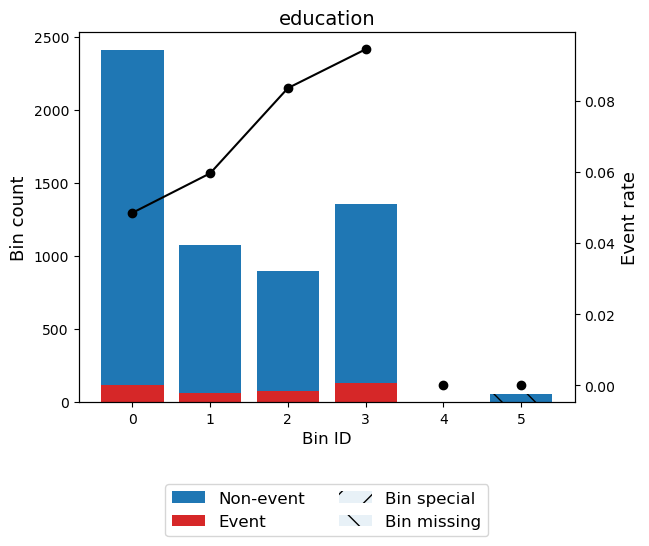

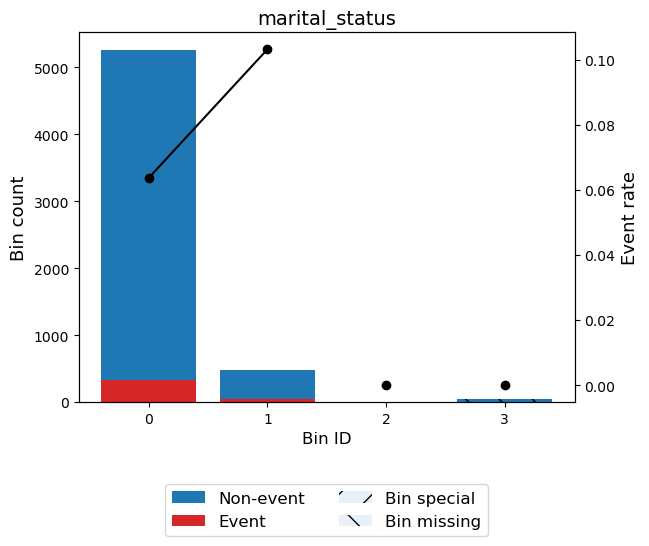

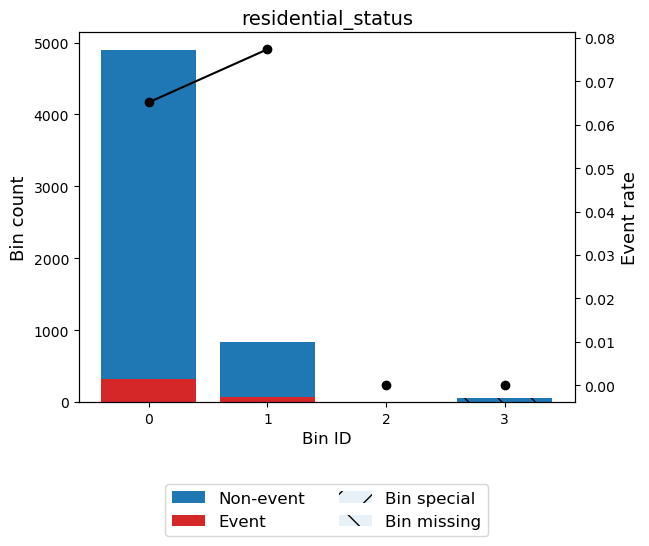

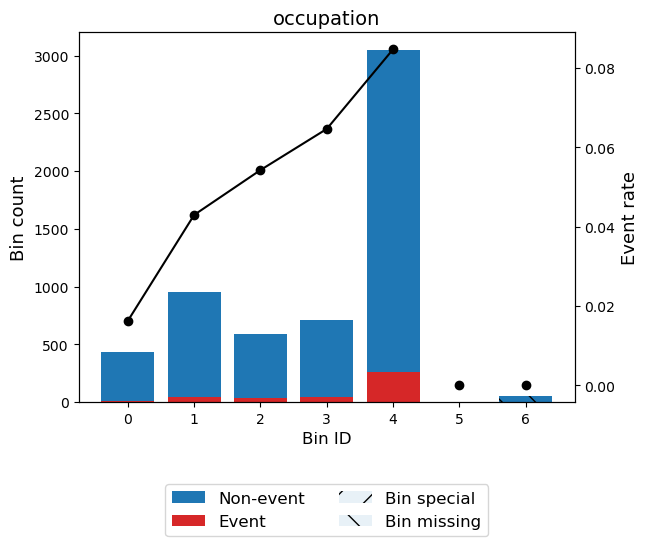

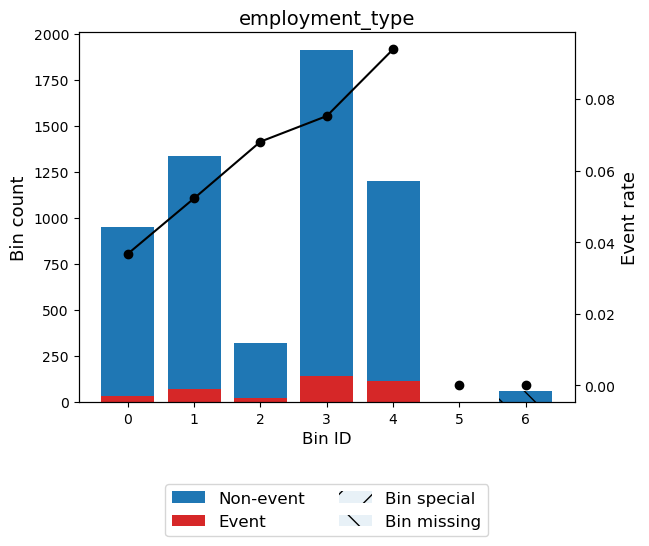

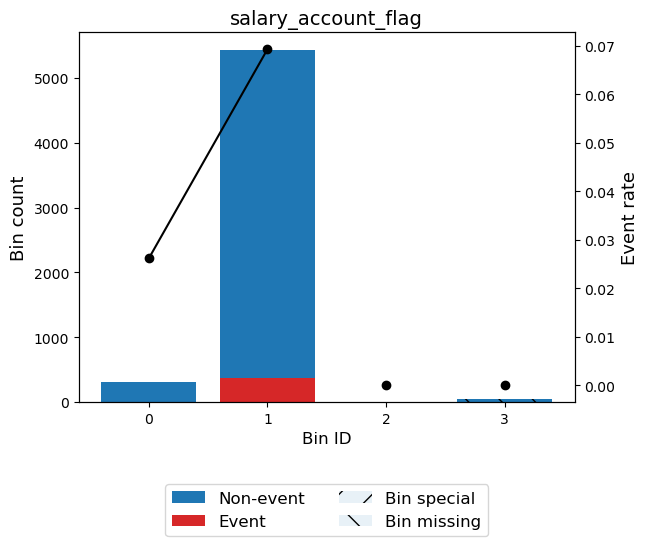

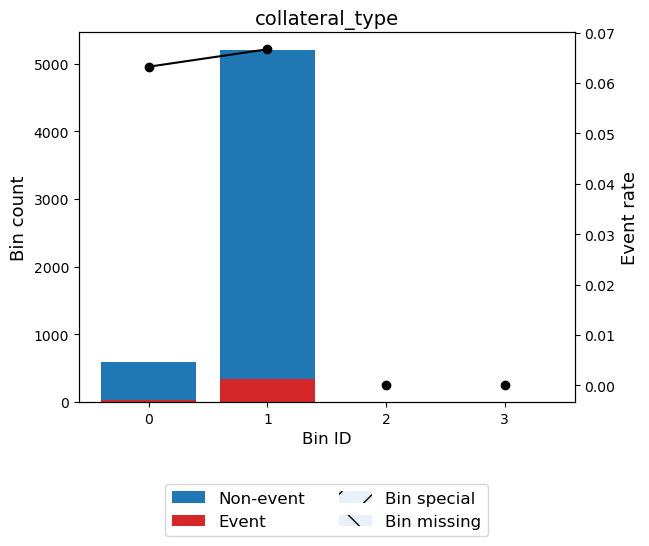

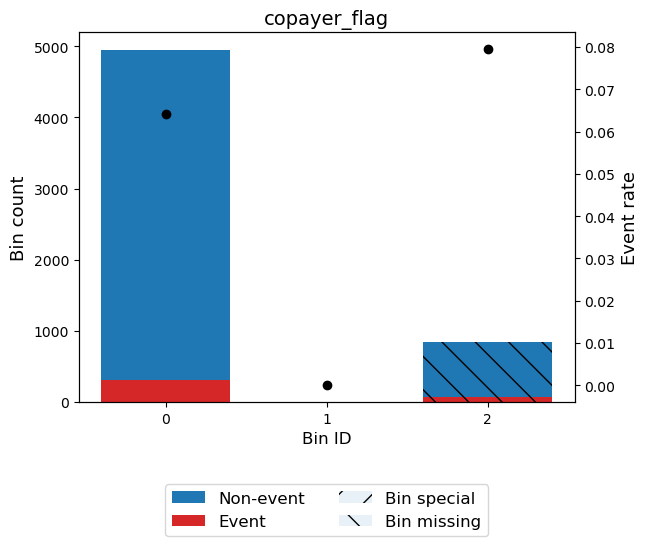

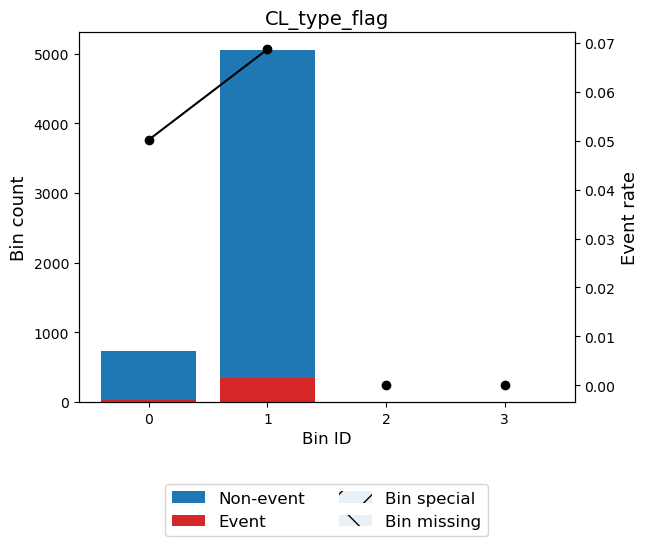

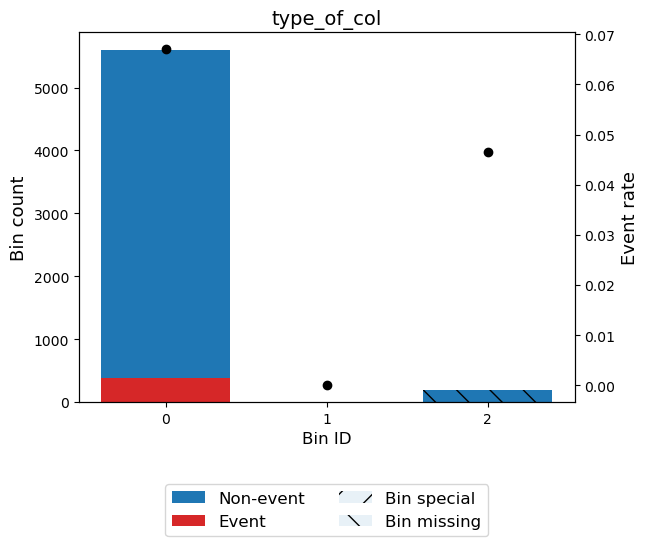

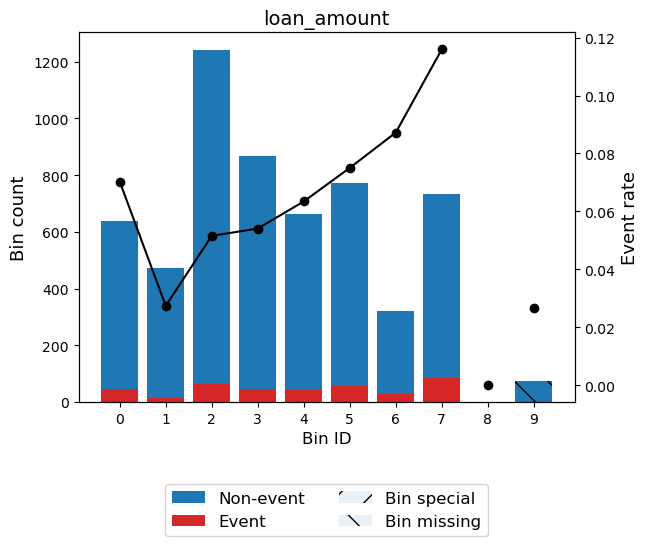

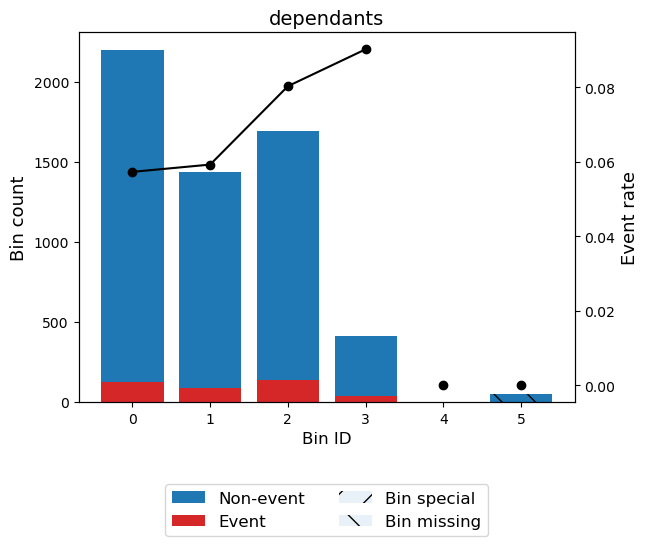

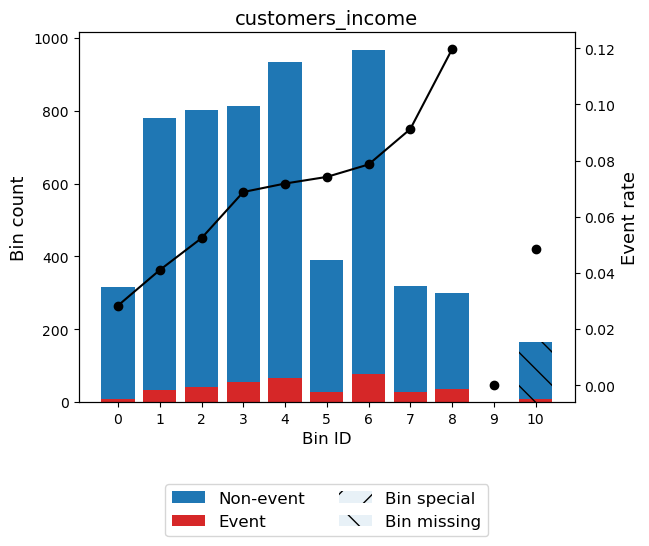

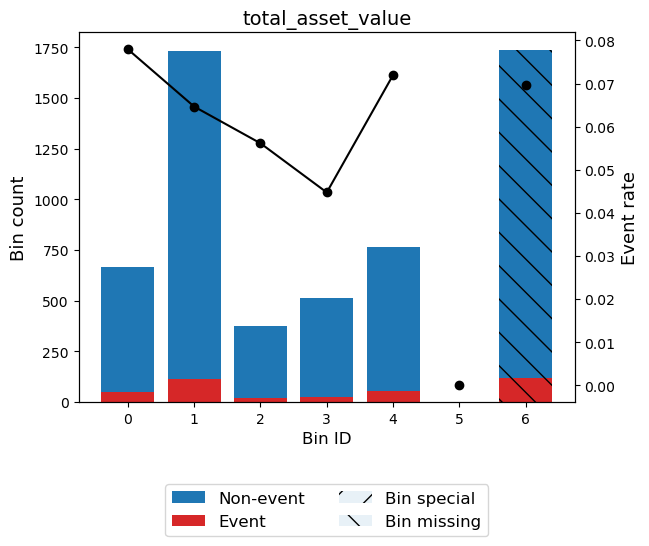

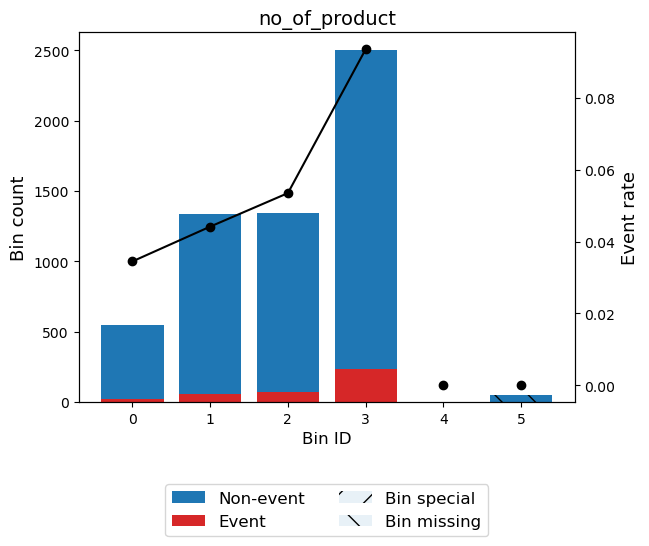

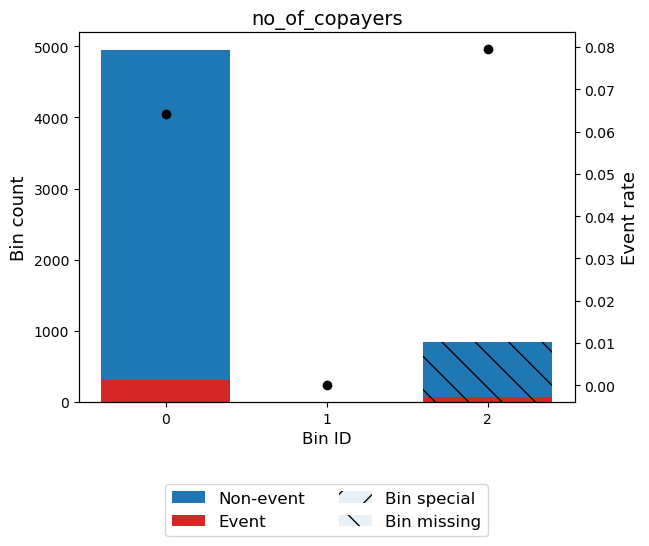

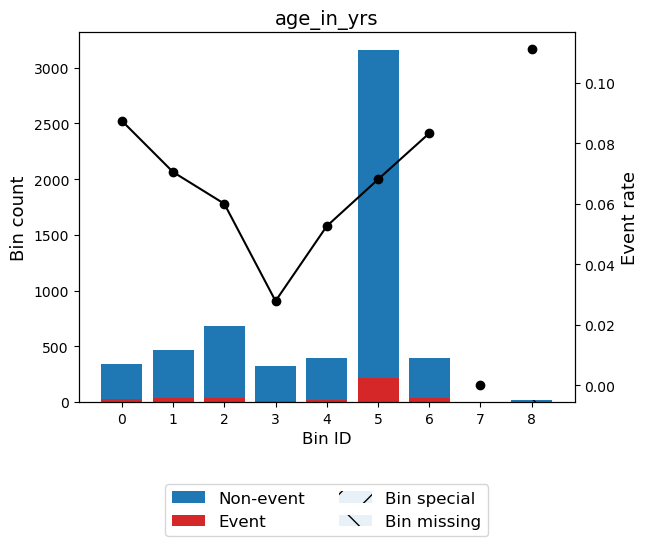

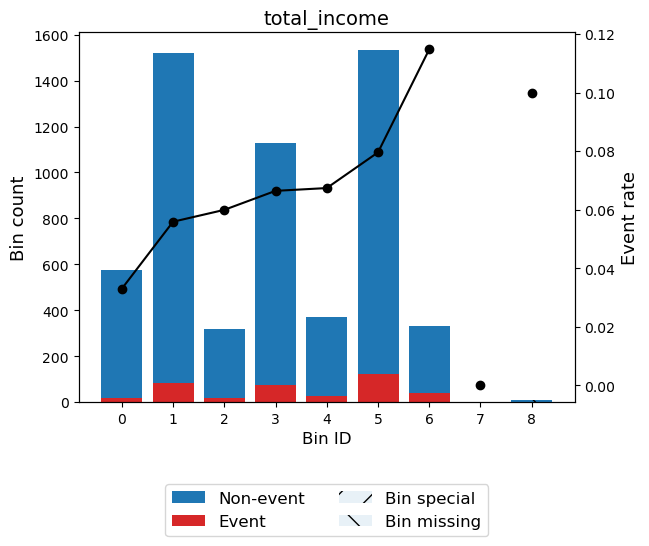

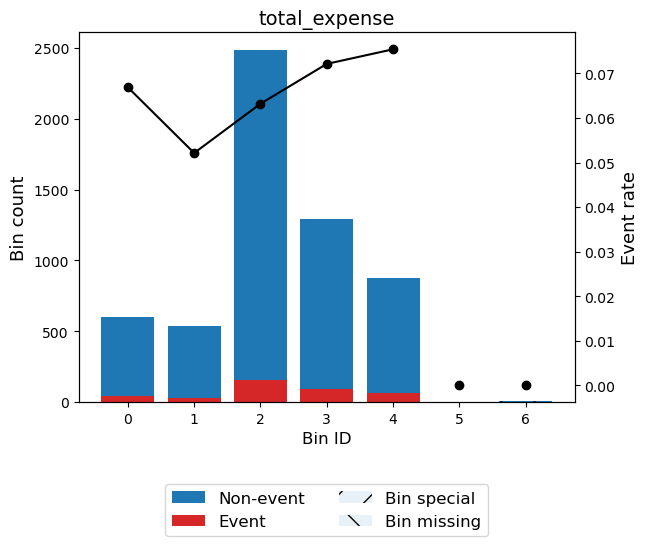

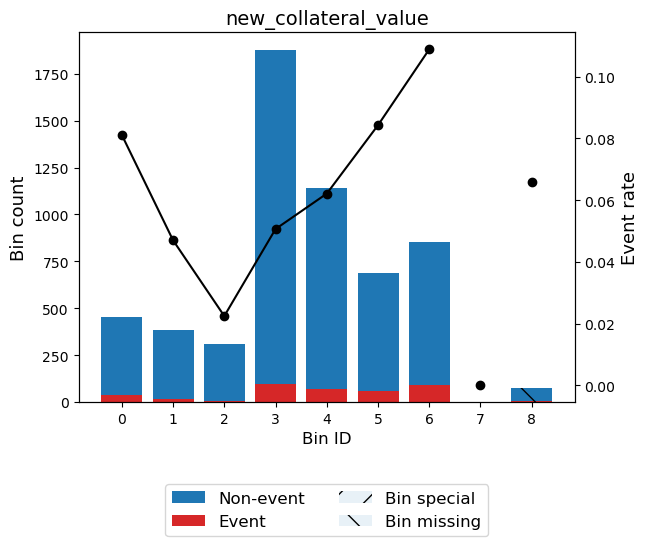

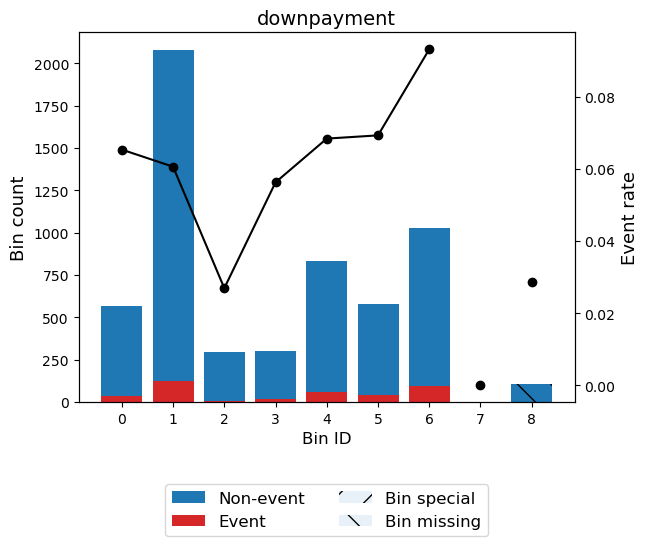

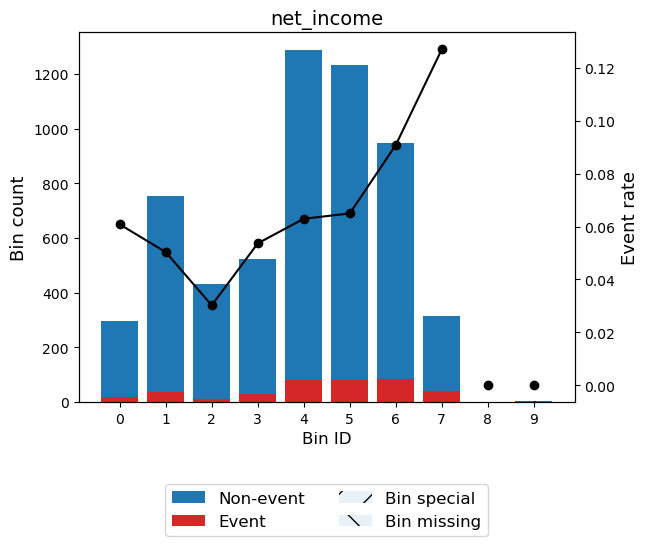

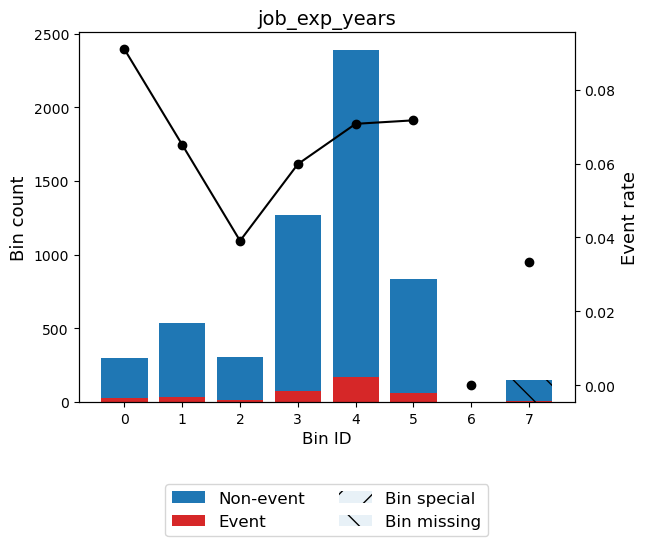

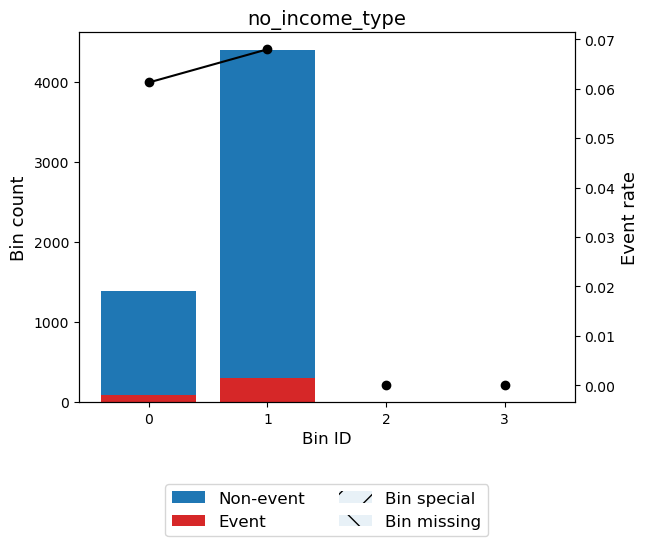

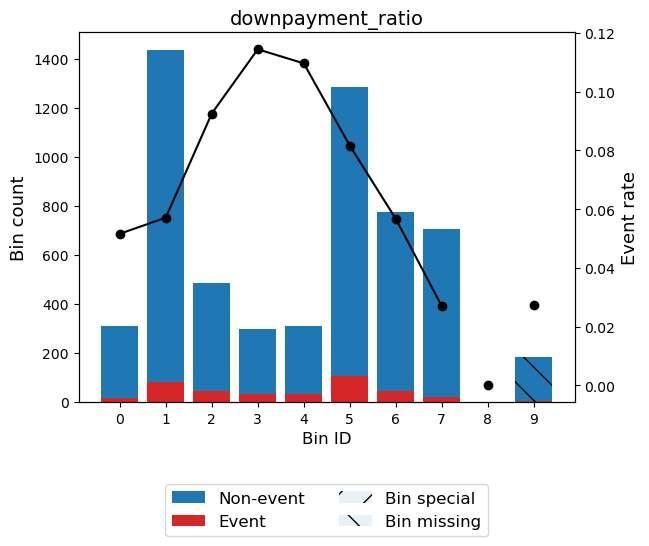

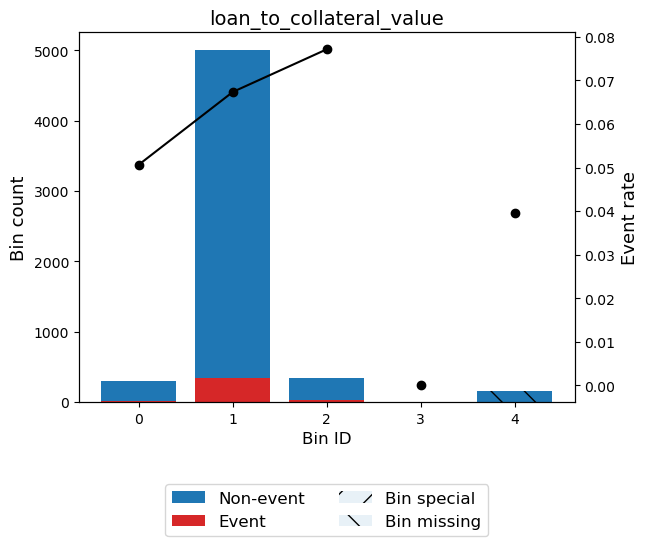

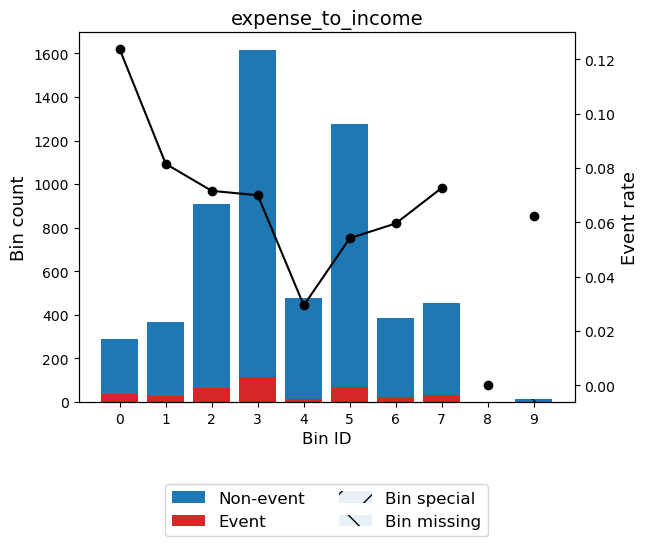

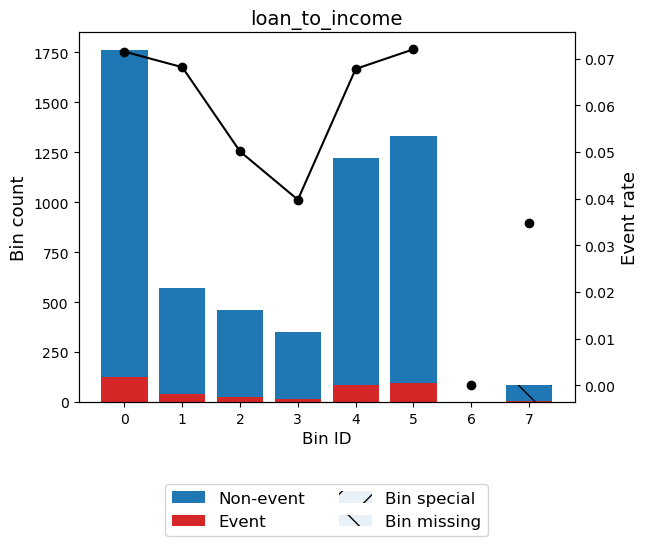

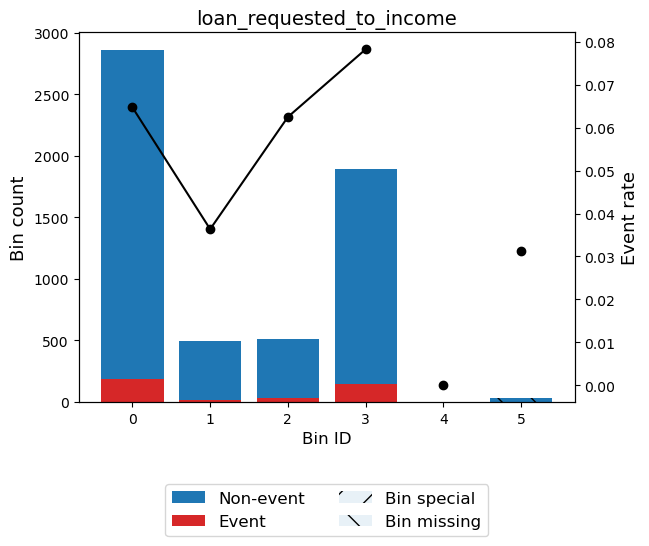

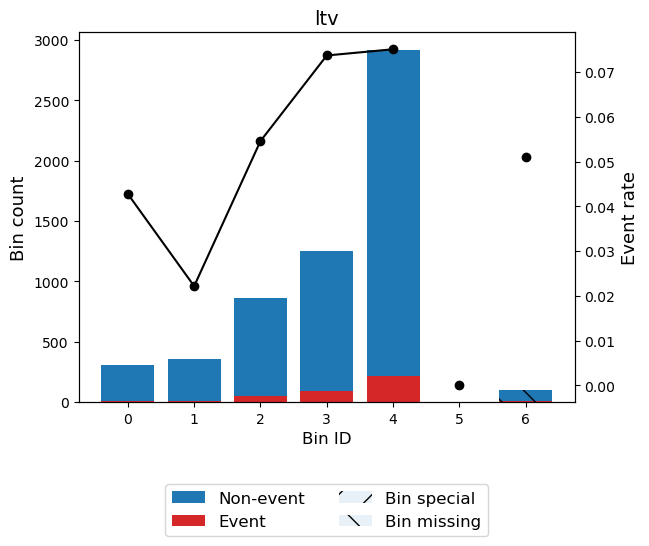

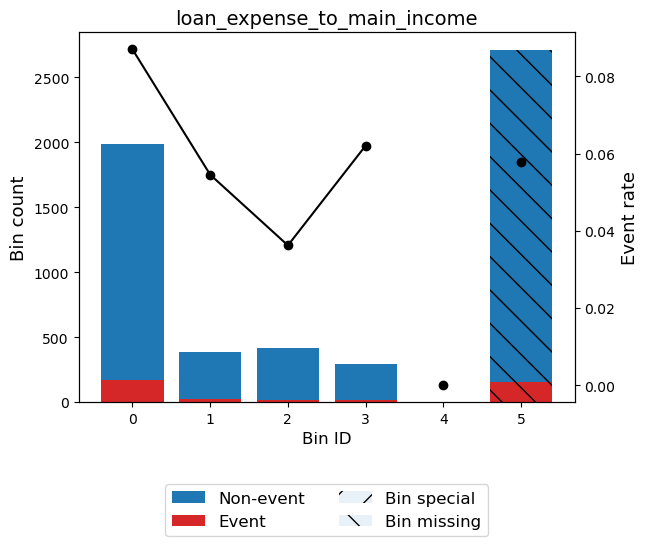

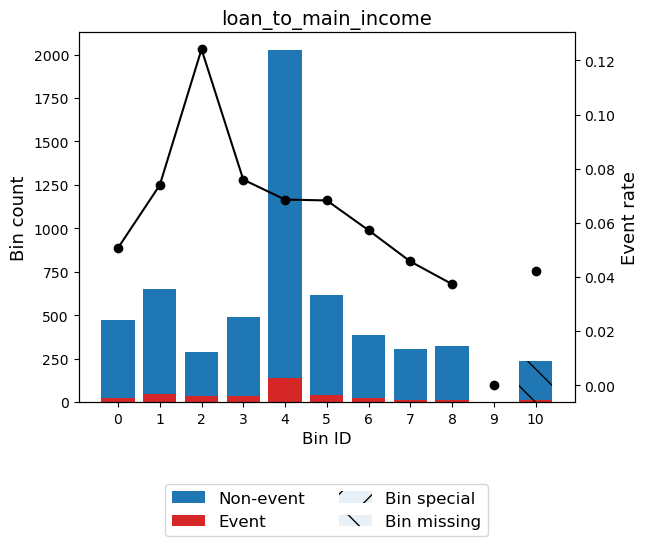

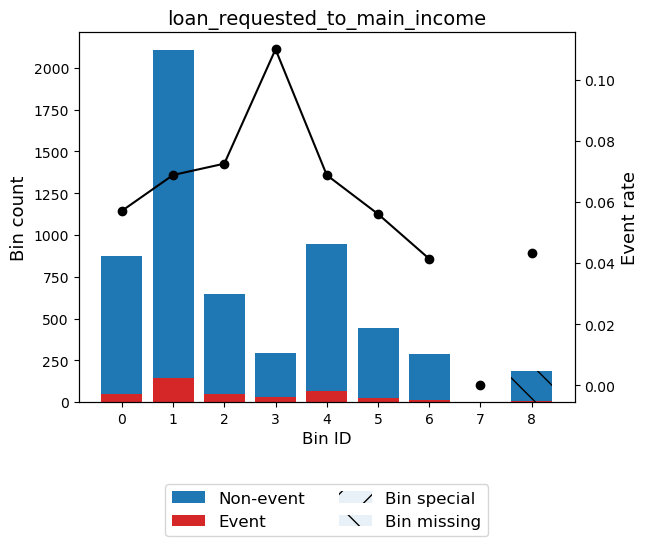

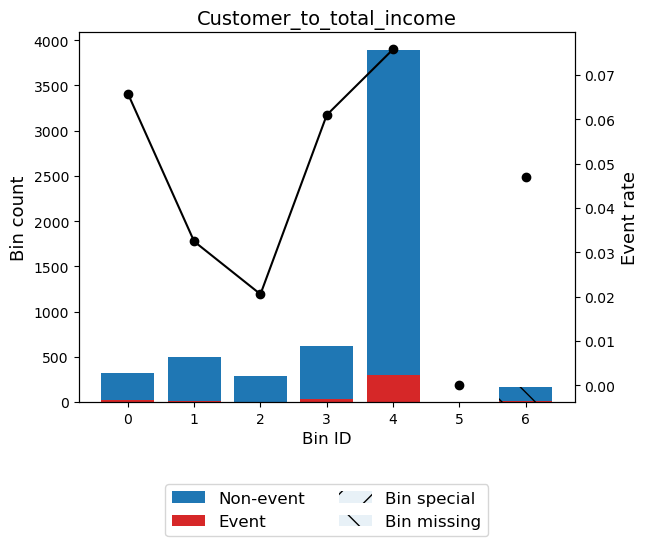

In [36]:
variable_names = dulieuktl1_train.columns.values
categorical_variables = dulieuktl1_train.select_dtypes(include = ["category","object"]).columns.values

X = dulieuktl1_train[variable_names]
y = dulieuktl1_train["y"].values

binning_process = BinningProcess(variable_names,
                                 categorical_variables=categorical_variables
                                )

binning_process.fit(X, y)

for variable in np.delete(variable_names,y):
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.plot(metric = "event_rate")

In [37]:
for variable in np.delete(variable_names,y):
    optb = binning_process.get_binned_variable(name=variable)
    print(optb.binning_table.build())

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0           [M]   4221   0.729267       3949    272    0.064440  0.031163   
1           [F]   1514   0.261576       1402    112    0.073976 -0.117096   
2       Special      0   0.000000          0      0    0.000000       0.0   
3       Missing     53   0.009157         53      0    0.000000       0.0   
Totals            5788   1.000000       5404    384    0.066344             

              IV        JS  
0       0.000699  0.000087  
1       0.003774  0.000471  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.004473  0.000559  
                                Bin  Count  Count (%)  Non-event  Event  \
0       [Post graduate, University]   2411   0.416551       2294    117   
1                         [College]   1073   0.185384       1009     64   
2                     [High school]    897   0.154976        822     75   
3                         [Diploma]   1354   0.233932       122

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 19.99)    310   0.053559        294     16    0.051613   
1       [19.99, 29.59)   1436   0.248100       1354     82    0.057103   
2       [29.59, 30.34)    486   0.083967        441     45    0.092593   
3       [30.34, 30.91)    297   0.051313        263     34    0.114478   
4       [30.91, 32.00)    310   0.053559        276     34    0.109677   
5       [32.00, 40.99)   1286   0.222184       1181    105    0.081649   
6       [40.99, 50.62)    776   0.134070        732     44    0.056701   
7         [50.62, inf)    705   0.121804        686     19    0.026950   
8              Special      0   0.000000          0      0    0.000000   
9              Missing    182   0.031444        177      5    0.027473   
Totals                   5788   1.000000       5404    384    0.066344   

             WoE        IV        JS  
0       0.266739  0.003398  0.000423  
1       0.159847  0.005916  0.000

=> Remove 3 variables,namely: 
-marital_status, salary_account_flag: more than 80% obs fall into 1 or 2 attributes
-collateral_type: Good/Bad line not showing monotonic trend clearly (Event_rates are quite simmilar through bins)

In [38]:
list1 = ['marital_status', 'salary_account_flag', 'collateral_type' ]

2.2. Accuracy ratio(AR) and IV (information value)

In [48]:
#Plot WOE trend for each variable

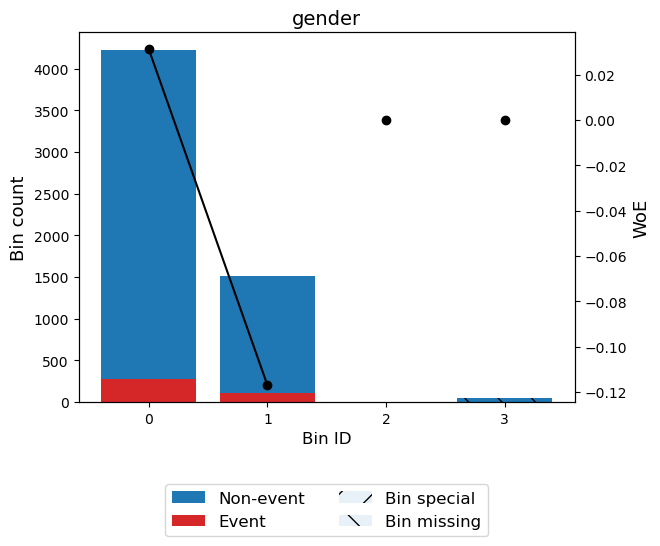

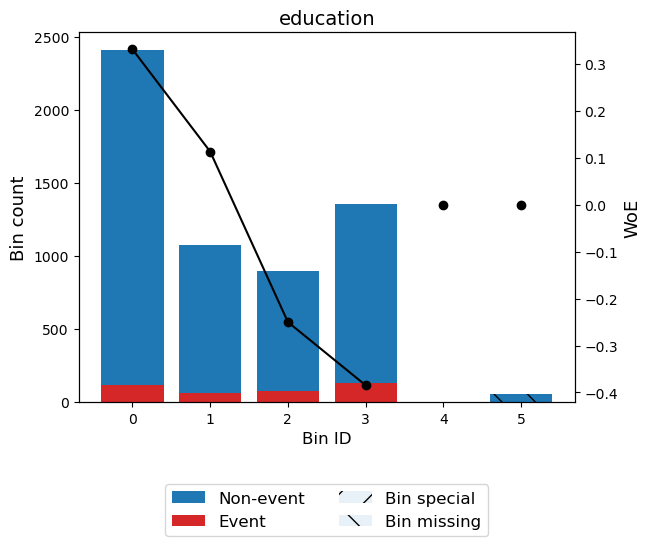

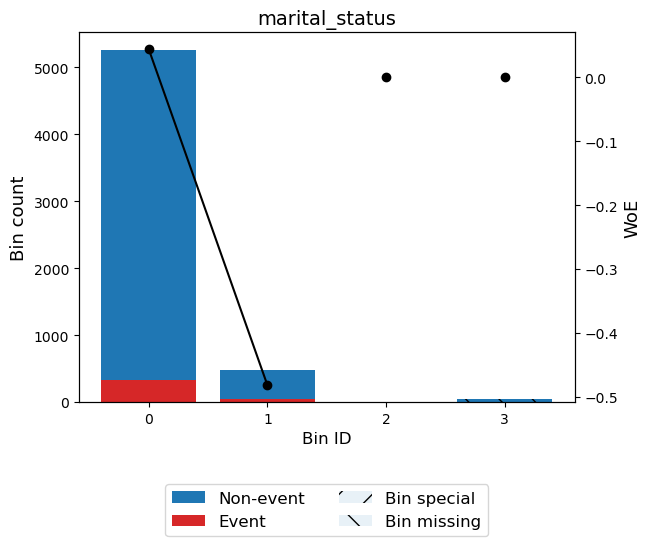

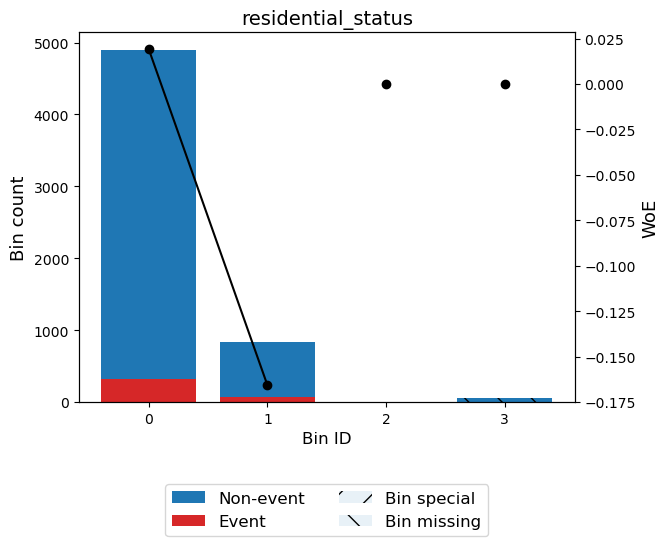

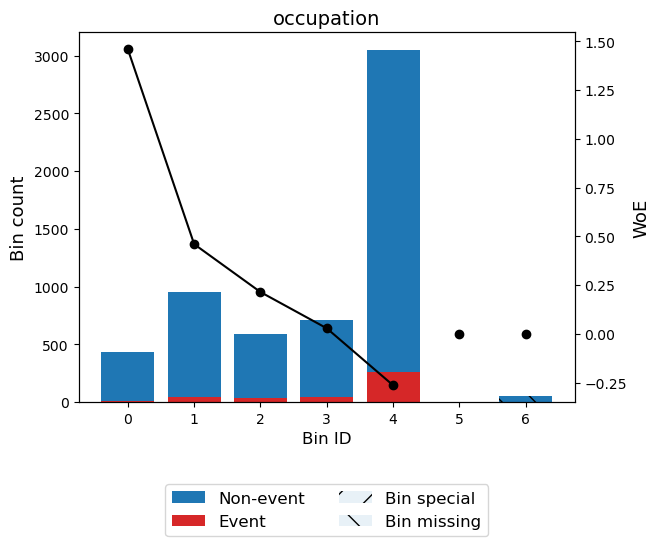

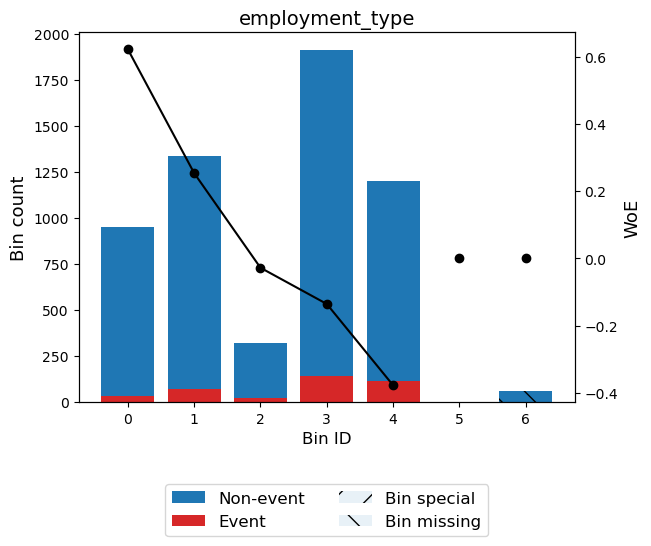

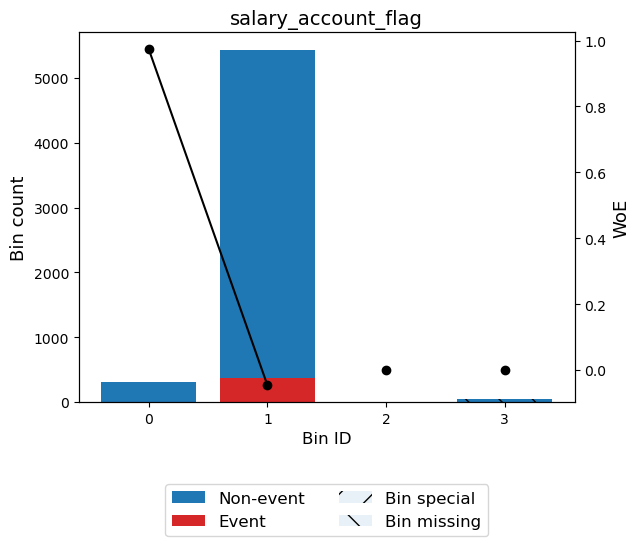

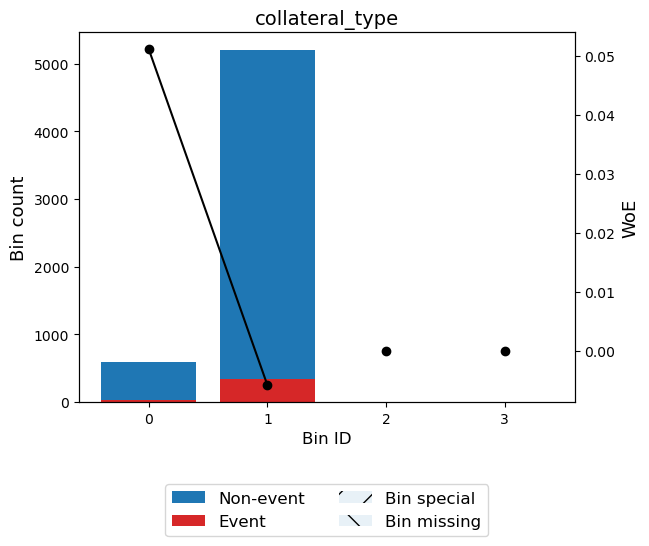

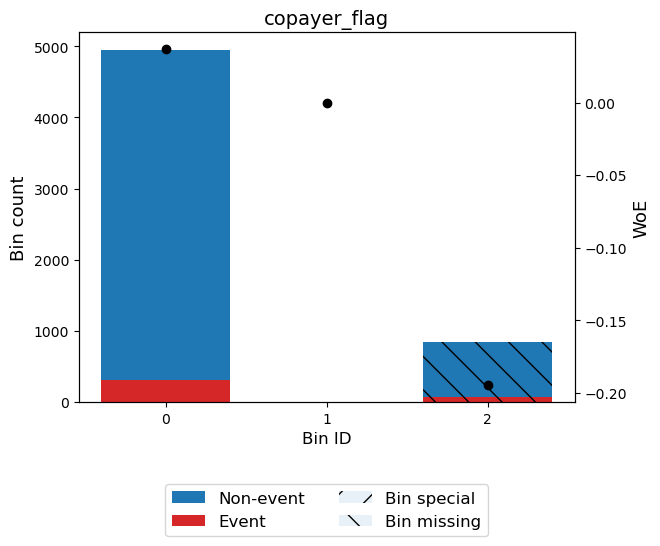

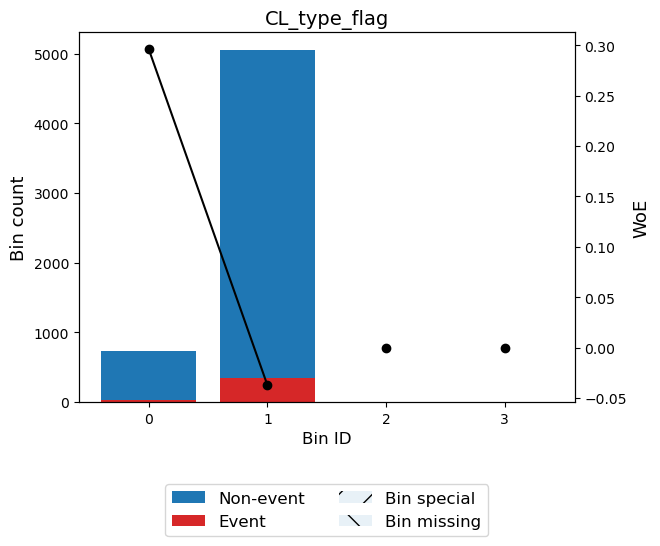

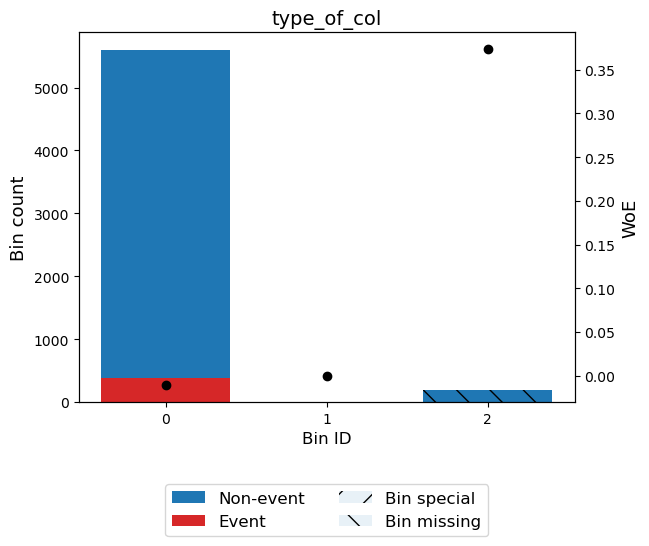

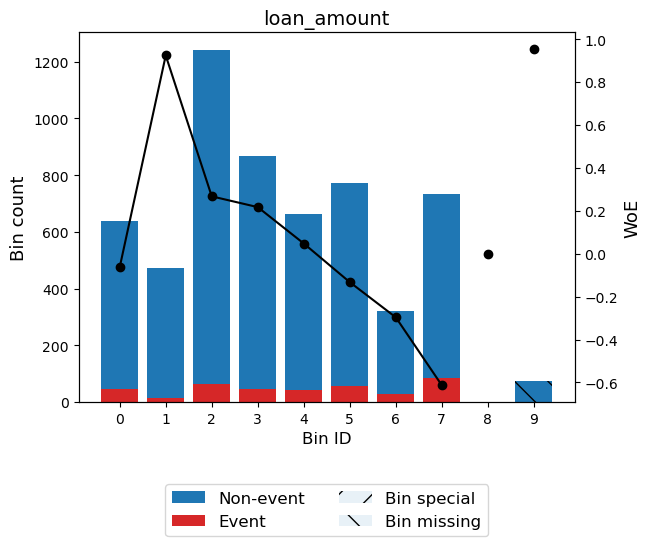

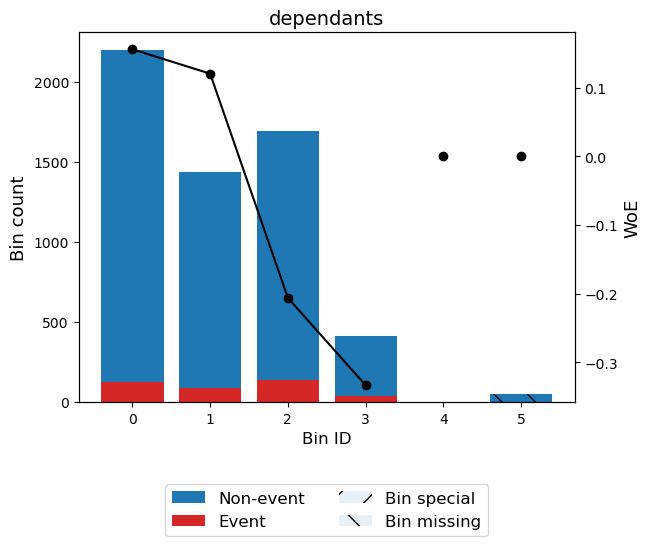

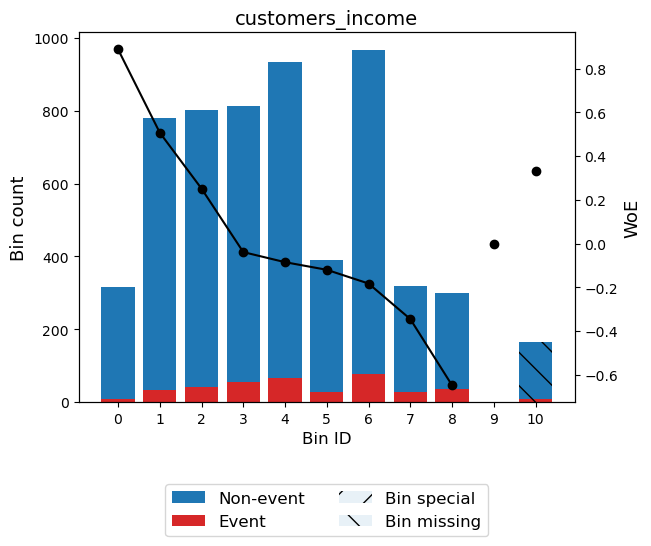

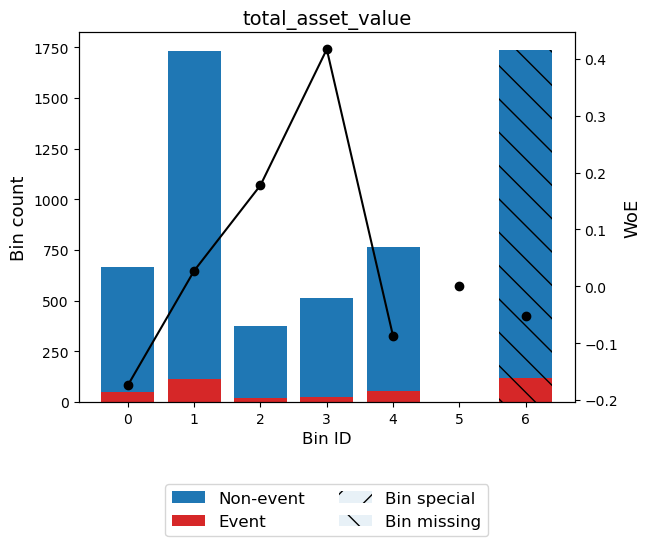

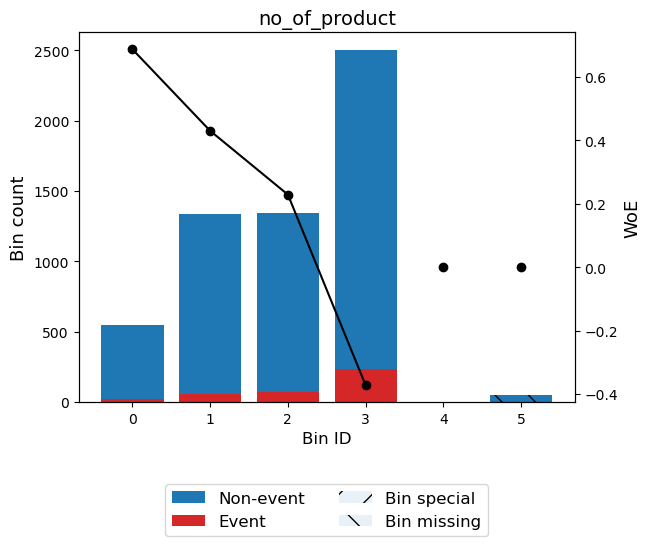

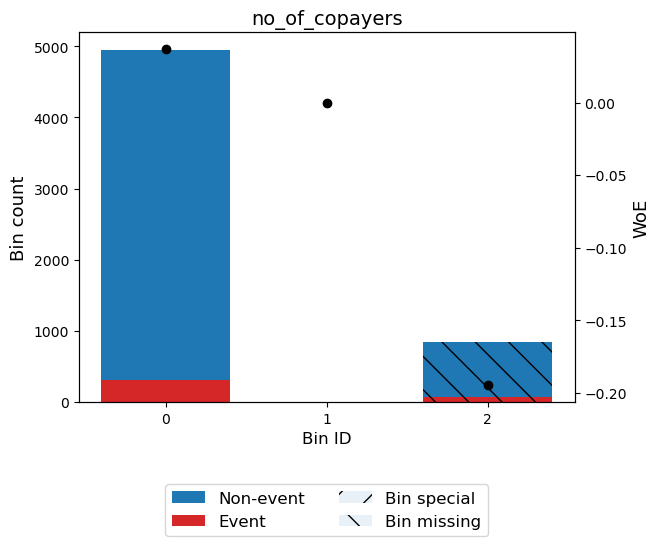

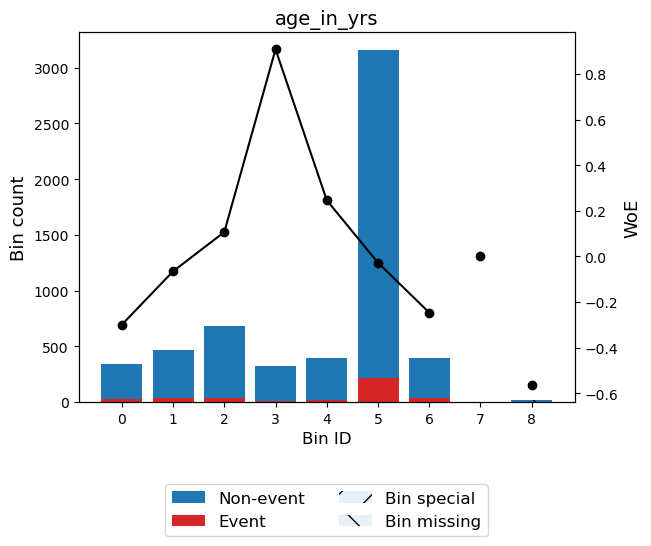

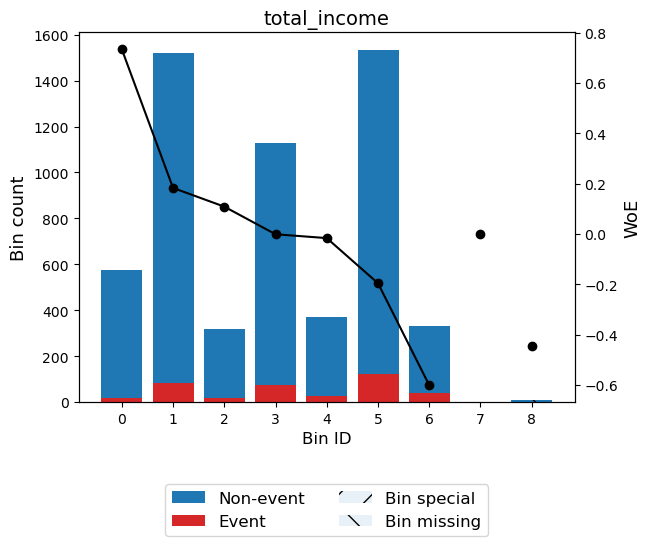

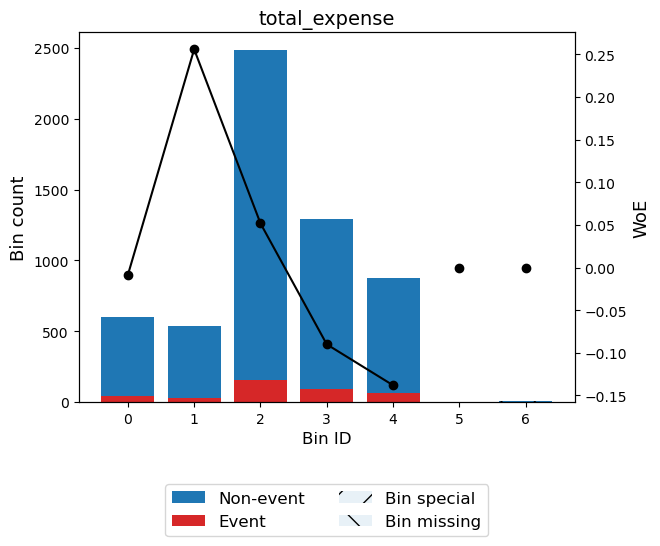

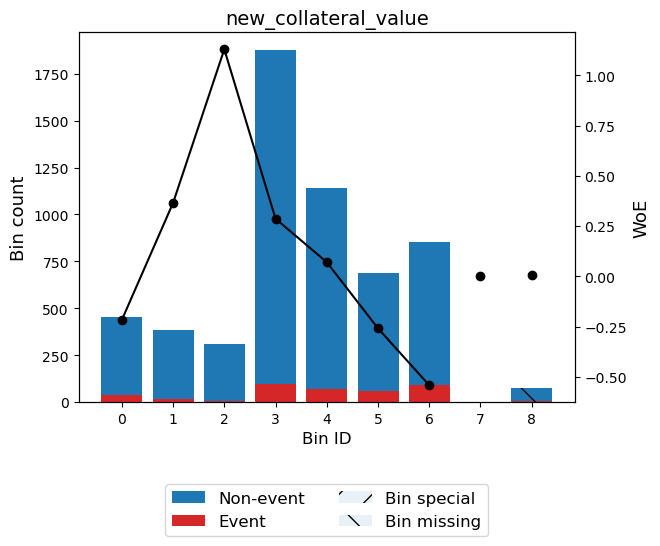

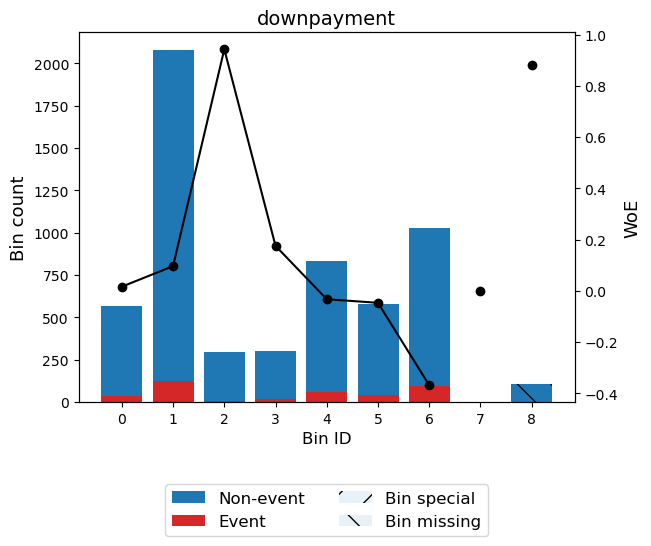

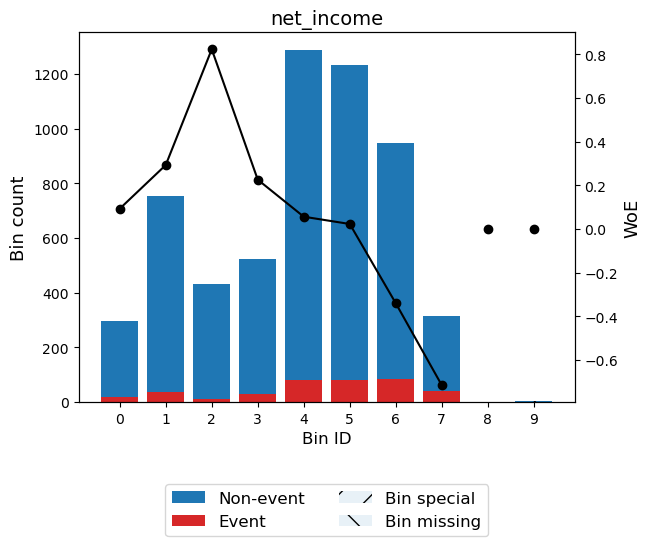

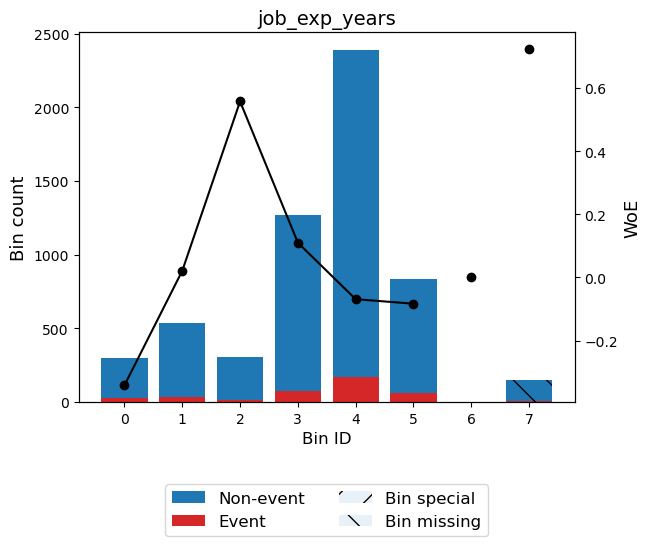

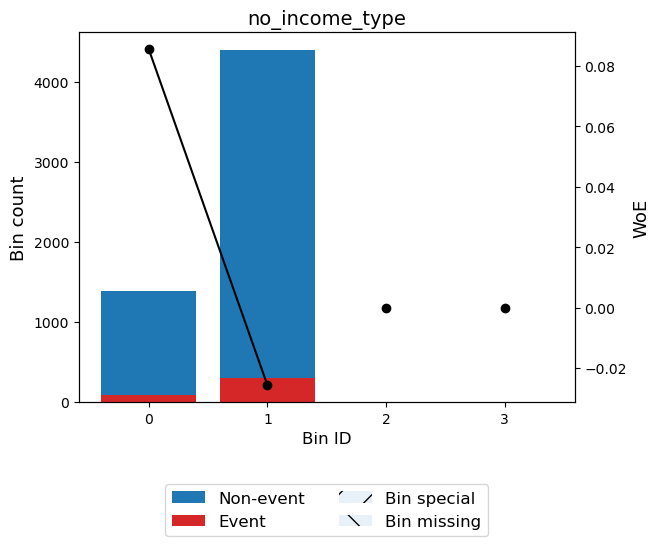

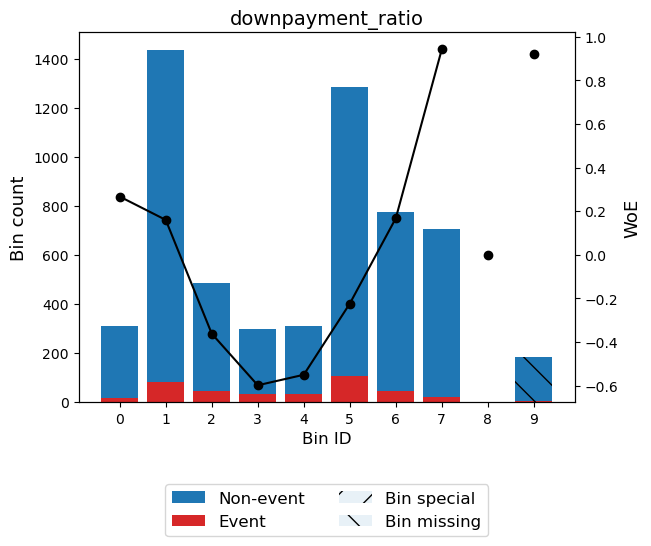

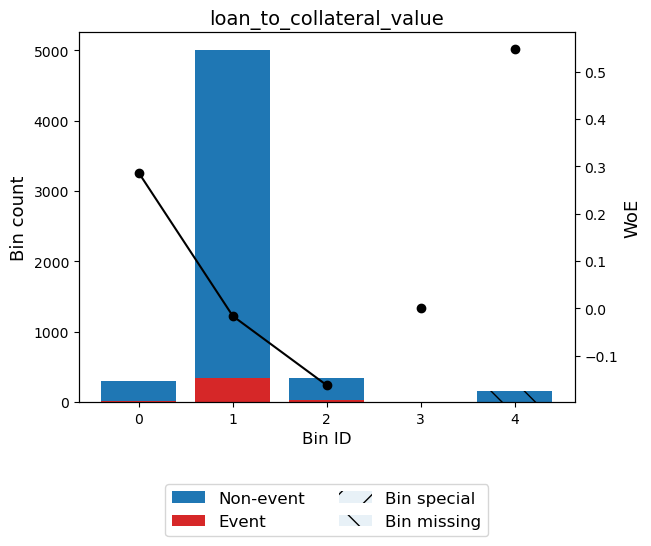

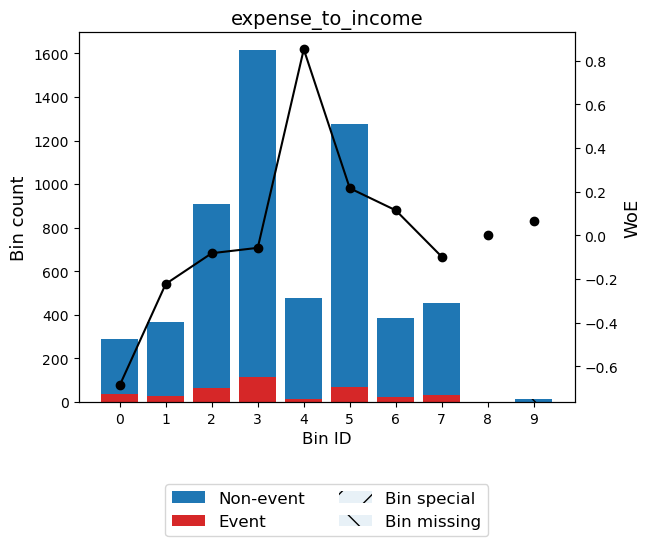

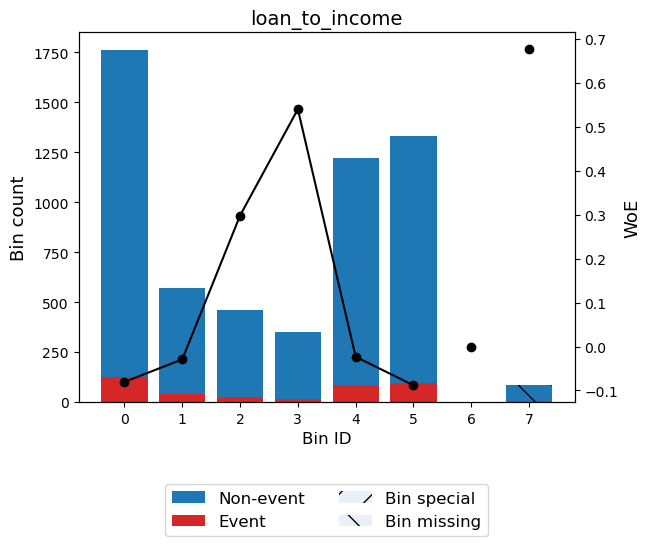

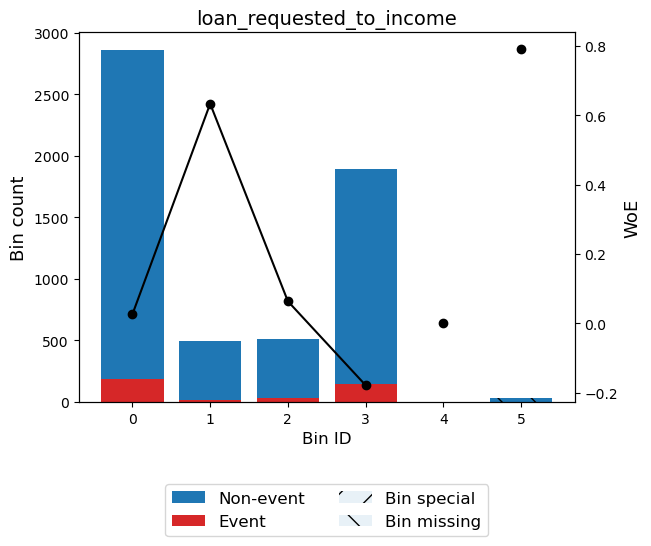

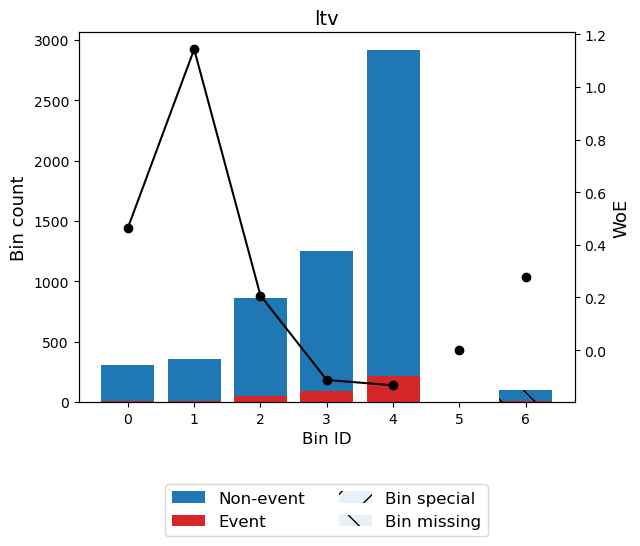

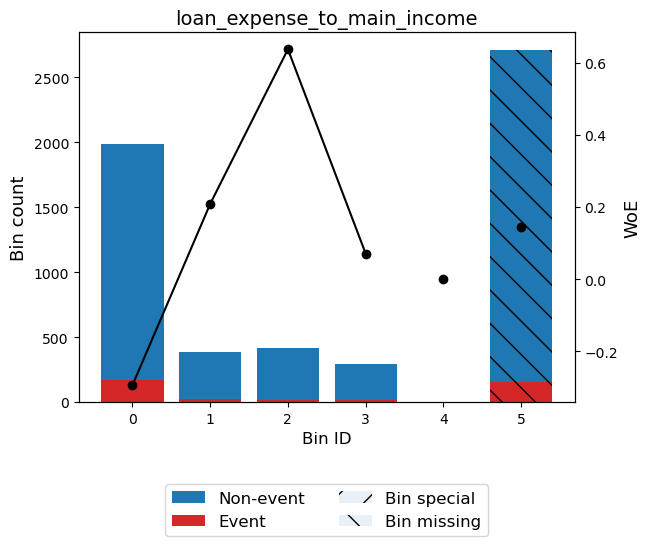

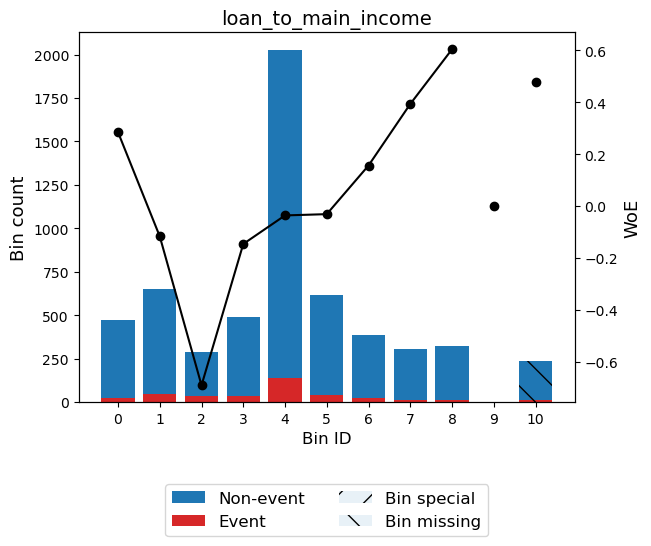

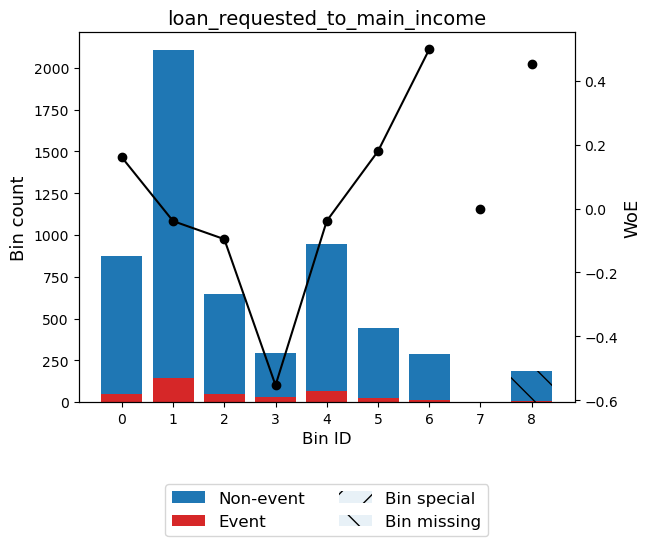

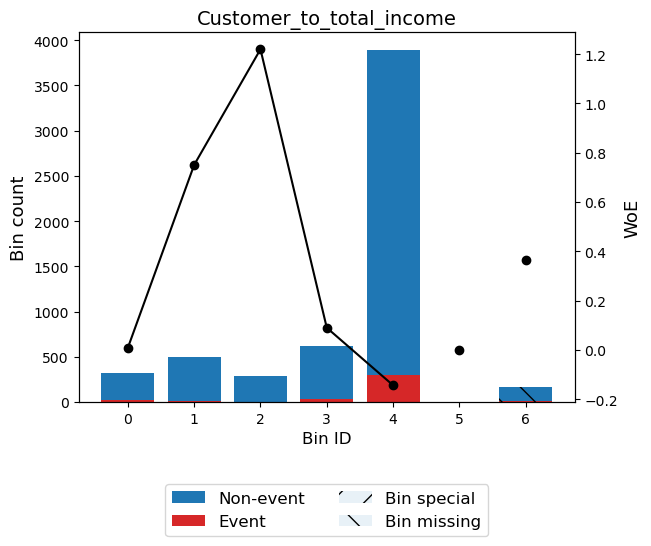

In [47]:
for variable in np.delete(variable_names,y):
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.plot(metric = "woe")

In [39]:
df5 = binning_process.summary()

In [40]:
type(df5)

pandas.core.frame.DataFrame

In [42]:
print(df5)

                             name        dtype   status  selected n_bins  \
0                               y  categorical  OPTIMAL      True      1   
1                        areaname  categorical  OPTIMAL      True      3   
2                          gender  categorical  OPTIMAL      True      2   
3                       education  categorical  OPTIMAL      True      4   
4                  marital_status  categorical  OPTIMAL      True      2   
5              residential_status  categorical  OPTIMAL      True      2   
6                      occupation  categorical  OPTIMAL      True      5   
7                 employment_type  categorical  OPTIMAL      True      5   
8             salary_account_flag  categorical  OPTIMAL      True      2   
9                 collateral_type  categorical  OPTIMAL      True      2   
10                   copayer_flag  categorical  OPTIMAL      True      1   
11                   CL_type_flag  categorical  OPTIMAL      True      2   
12          

In [43]:
df6 = df5[(df5['gini'] < 0.1) | (df5['iv'] < 0.1)]
df6

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,y,categorical,OPTIMAL,True,1,0.0,0.0,0,0.0
2,gender,categorical,OPTIMAL,True,2,0.004473,0.000559,0.039176,0.007916
3,education,categorical,OPTIMAL,True,4,0.093775,0.011664,0.174544,0.161537
4,marital_status,categorical,OPTIMAL,True,2,0.025194,0.003121,0.05733,0.023344
5,residential_status,categorical,OPTIMAL,True,2,0.004594,0.000574,0.034006,0.005443
8,salary_account_flag,categorical,OPTIMAL,True,2,0.035432,0.004272,0.044323,0.022923
9,collateral_type,categorical,OPTIMAL,True,2,0.000289,0.000036,0.005255,0.000073
10,copayer_flag,categorical,OPTIMAL,True,1,0.00715,0.000893,0.030882,0.011118
11,CL_type_flag,categorical,OPTIMAL,True,2,0.011059,0.001378,0.03318,0.012836
12,type_of_col,categorical,OPTIMAL,True,1,0.004079,0.000507,0.010611,0.001643


These are characteristics to remove from model building sample due to unsatisfactory IV and AR (i.e gini coefficient);
However, education, total_income and customer_to_total_income not performing too badly and having business-sense as well.
=> I decide to keep them in the list for next analysis.

In [57]:
list2 = df6['name'].values

In [67]:
to_keep = ['y','education','total_income','Customer_to_total_income']
for varkept in to_keep:
    list2 = np.delete(list2, np.where(list2 == varkept))

In [68]:
list2

array(['gender', 'marital_status', 'residential_status',
       'salary_account_flag', 'collateral_type', 'copayer_flag',
       'CL_type_flag', 'type_of_col', 'dependants', 'total_asset_value',
       'no_of_copayers', 'age_in_yrs', 'total_expense', 'downpayment',
       'job_exp_years', 'no_income_type', 'loan_to_collateral_value',
       'expense_to_income', 'loan_to_income', 'loan_requested_to_income',
       'ltv', 'loan_expense_to_main_income', 'loan_to_main_income',
       'loan_requested_to_main_income'], dtype=object)

In [45]:
list1 = np.array(list1)

In [69]:
list3 = np.concatenate((list1, list2))
list3

array(['marital_status', 'salary_account_flag', 'collateral_type',
       'gender', 'marital_status', 'residential_status',
       'salary_account_flag', 'collateral_type', 'copayer_flag',
       'CL_type_flag', 'type_of_col', 'dependants', 'total_asset_value',
       'no_of_copayers', 'age_in_yrs', 'total_expense', 'downpayment',
       'job_exp_years', 'no_income_type', 'loan_to_collateral_value',
       'expense_to_income', 'loan_to_income', 'loan_requested_to_income',
       'ltv', 'loan_expense_to_main_income', 'loan_to_main_income',
       'loan_requested_to_main_income'], dtype=object)

=> List3: variables to be discarded

#As can be seen, some variables chosen for latter stages have monotonic WOE trend, which is expected to serve logistic regression. The remainings have an U-shaped curve with respect to WOE though, and this trend may be reflecting actual
behavior. For example, at first very low loan_amount is higher risk (negative WOE), then the risk decreases up to a point, and finally risk starts increasing as loan_amount increases. This relationship should be kept, as long as it can be explained.

In [71]:
dulieuktl2_train = dulieuktl1_train.drop(list3, axis=1)

In [81]:
dulieuktl2_train

,y,areaname,education,occupation,employment_type,loan_amount,customers_income,no_of_product,total_income,new_collateral_value,net_income,downpayment_ratio,Customer_to_total_income
371,1,Southern,High school,Own business,Registered business,3.297000e+08,15000000.0,1.0,15000000.0,3.297000e+08,9500000.0,30.24,100.00
5101,0,Northern,University,Expert/Researcher,Specialist,6.141600e+08,47000000.0,1.0,47000000.0,6.141600e+08,22000000.0,20.22,100.00
4139,0,Middle,Diploma,Own business,Worker or self-employed person,1.410580e+09,36000000.0,2.0,36000000.0,1.365000e+09,29000000.0,39.74,100.00
1919,0,Northern,High school,Own business,Registered business,2.600000e+08,23000000.0,0.0,23000000.0,2.600000e+08,8000000.0,50.00,100.00
4194,0,Middle,High school,Own business,Registered business,1.330000e+09,36500000.0,2.0,36500000.0,1.330000e+09,23500000.0,93.76,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,Northern,Diploma,Other (retired…),Retired,5.500000e+08,24488600.0,0.0,32888600.0,2.080000e+09,27888600.0,27.27,74.46
5191,0,Middle,Diploma,Own business,Registered business,3.700000e+08,21000000.0,1.0,49000000.0,3.700000e+08,9900000.0,32.43,42.86
5226,0,Northern,Diploma,Own business,Registered business,6.270000e+08,50000000.0,1.0,50000000.0,6.270000e+08,26000000.0,44.18,100.00
5390,0,Southern,High school,Own business,Worker or self-employed person,1.510000e+09,51100000.0,0.0,51100000.0,1.510000e+09,28100000.0,20.53,100.00


2.3 Correlation 

C:\Users\HANG\AppData\Local\Temp\ipykernel_12452\3655149936.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dulieuktl2_train.corr(method='pearson'), annot=True);


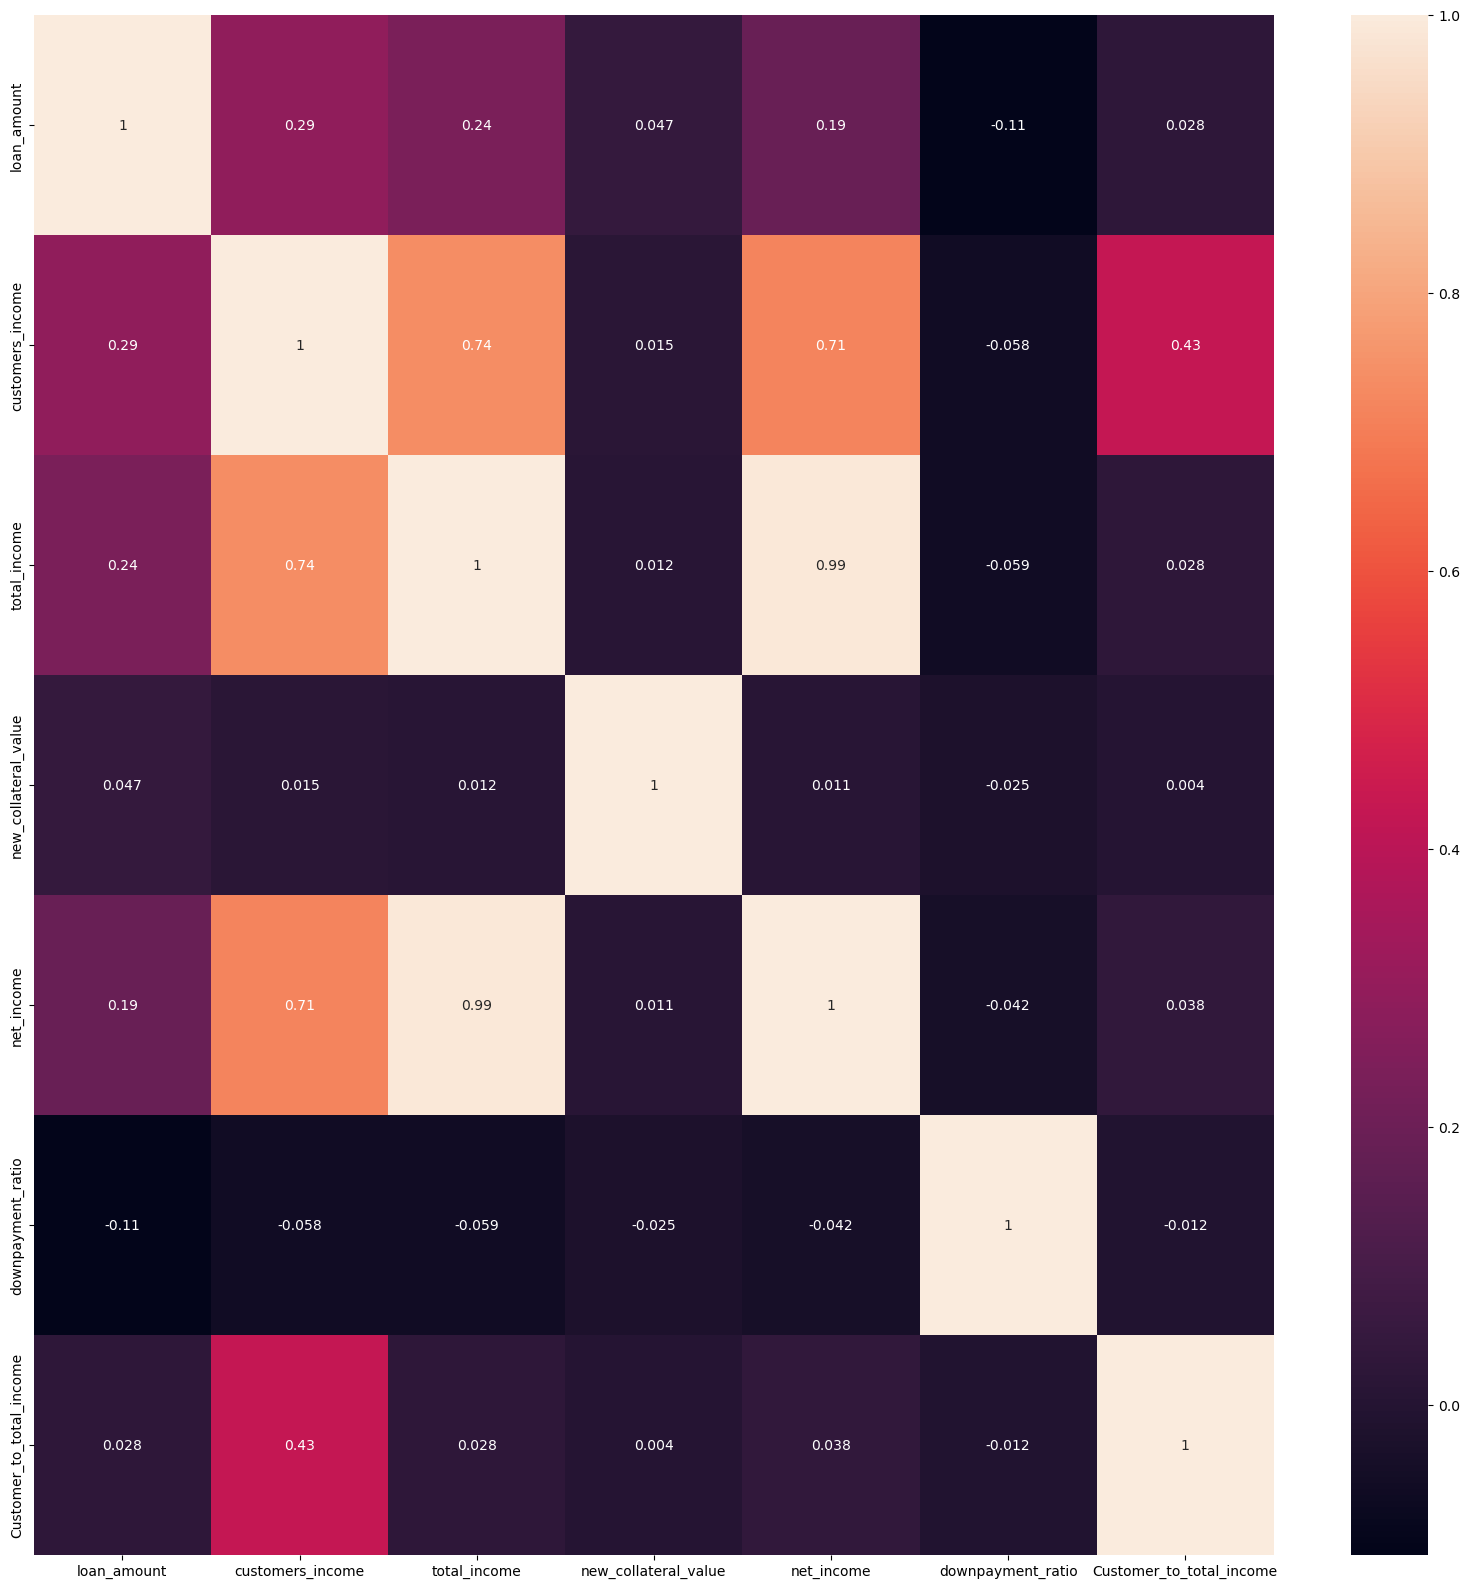

In [74]:
# Plot correlation matrix using Pearson coefficient
plt.figure(figsize=(20,20))
sns.heatmap(dulieuktl2_train.corr(method='pearson'), annot=True);

=> It is obvious that pairs of 2 variables in 'customers_income' , 'net_income' and 'total_income' have such a high correlation coefficient. I will keep only 'customers_income' in the short list for MFA cause it has the highest IV and gini values.

In [92]:
dulieuktl3_train = dulieuktl2_train.drop(columns=['net_income','total_income'])

#Note: 
I intended to run logistic regression between each variable in the short list and the target y.
Futhermore, the regression is not against the input, but rather against the WOE of each grouping created in the previous step. 
So there must have been some code lines where you can see me transform inputs into corresponding WOE values (Stage 3: Variables transformation)
These WOE values can be regarded as "score" of each attribute of each variable though they should be standardized so that comparing
characteristics together become easier and more intuitive (i.e all scores are transformed to have the same mean 0 and standard deviation 1, 
then scaling process can return score interval like [-100;100])
After all, I can examine sign of coefficients, p-values undertake T-test on the output table to be confident that all variables in the shortlist
are satified to run MFA.

In multiple factor analysis stage, Stepwise regression would be employed, numbers of combinations of variables would be analyzed based on list of criteria
including: p-values, models AR, business meaning,... to gain the best combination. This final model does best in predicting the default probability of customers.

However, this time I will try Scorecard package to help

In [103]:
# Define the feature list from dataset (including categorical and numerical)
list_features = dulieuktl3_train.drop(columns=['y']).columns.values

# Define categorical features list
list_categorical = dulieuktl3_train.drop(columns=['y']).select_dtypes(include=['object', 'category']).columns.values

# Instatiate BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features
    )

# Define logisticRegression method
logreg = LogisticRegression(C=3, max_iter=1000, random_state=161)

# Define scaling method and values
'khong co tai lieu nao nhac den min_max la sao'
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 100}

# Instatiate and fit Scorecard
scorecard = Scorecard(
 
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=False,
    reverse_scorecard=True
    )

scorecard.fit(dulieuktl3_train.drop(columns=['y']),y_train)

scorecard_summary = scorecard.table(style="detailed").round(3)

In [100]:
print(scorecard_summary.to_string())

                    Variable  Bin id                                                                                                                                                                  Bin  Count  Count (%)  Non-event  Event  Event rate    WoE     IV     JS  Coefficient  Points
0                   areaname       0                                                                                                                                                           [Northern]   2900      0.501       2771    129       0.044  0.423  0.075  0.009       -0.774   9.173
1                   areaname       1                                                                                                                                                           [Southern]   1667      0.288       1519    148       0.089 -0.316  0.033  0.004       -0.774  -0.907
2                   areaname       2                                                                                        

5. Model validation

Finally, I can visualize my Scorecard performance using functions from optbinning.scorecard.plots module.

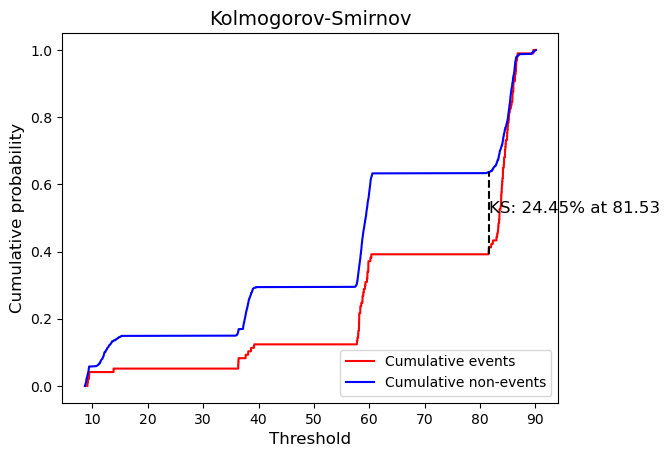

In [118]:
from optbinning.scorecard.plots import plot_ks, plot_auc_roc

# Assign score and predicted probability to test dataset
dulieuktl1_test.loc[:,"score"] = scorecard.score(dulieuktl1_test)

# Kolmogorov_Smirnov Plot
plot_ks(dulieuktl1_test.y, dulieuktl1_test.score)

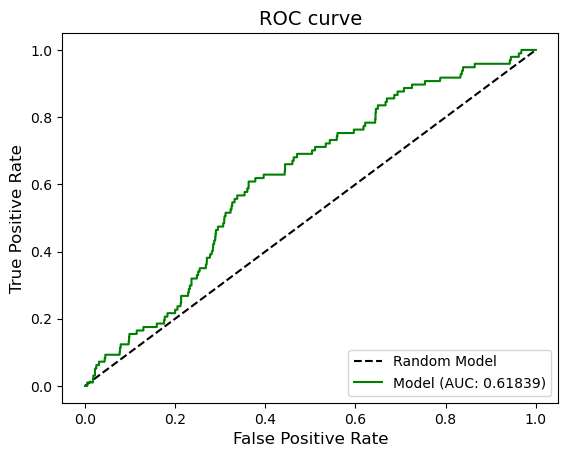

In [119]:
# ROC-AUC plot
plot_auc_roc(dulieuktl1_test.y, dulieuktl1_test.score)

The Kolmogorov_Smirnov Plot seems kind of weird (honestly, strange to me), so I need more time to think about it!
Anyway, this is the end of my project. Thanks for watching!